# HRRR-MODIS net solar representation check

In [1]:
from pathlib import PurePath
import sys
import os
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import pyproj

import pandas as pd

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# Locate pyproj_datadir for studio env
# From https://stackoverflow.com/questions/69630630/on-fresh-conda-installation-of-pyproj-pyproj-unable-to-set-database-path-pypr
CONDA_ENV = 'studio'
miniconda_dir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3'
proj_version = h.fn_list(miniconda_dir, f'envs/{CONDA_ENV}/conda-meta/proj-[0-9]*.json')[0]

VERSION = PurePath(proj_version).stem
pyprojdatadir = f'{miniconda_dir}/pkgs/{VERSION}/share/proj'
print(pyprojdatadir)
pyproj.datadir.set_data_dir(pyprojdatadir)

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj


## Directory

In [4]:
basin = 'animas'
WY = 2021
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts'

In [5]:
snotel_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/ancillary_sdswe_products/SNOTEL'
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts'

# Basin polygon file
poly_fn = h.fn_list(script_dir, f'*{basin}*setup/polys/*shp')[0]

# SNOTEL all sites geojson fn
allsites_fn = h.fn_list(snotel_dir, 'snotel_sites_32613.json')[0]

# Locate SNOTEL sites within basin
found_sites = proc.locate_snotel_in_poly(poly_fn=poly_fn, site_locs_fn=allsites_fn, buffer=200)

# Get site names and site numbers
sitenames = found_sites['site_name']
sitenums = found_sites['site_num']
print(sitenames)

ST_arr = ['CO'] * len(sitenums)
gdf_metloom, snotel_dfs, snotel_metadf = proc.get_snotel(sitenums, sitenames, ST_arr, WY=int(WY), return_meta=True)

32613
148           Cascade #2 (387)
199        Mineral Creek (629)
200           Molas Lake (632)
213    Red Mountain Pass (713)
225        Spud Mountain (780)
Name: site_name, dtype: object


# Read in pre-existing extracts

In [ ]:
extract_fns = h.fn_list(workdir, f'*{basin}*{WY}*.*')
# Remove any files with "only" in the name
extract_fns = [f for f in extract_fns if 'only' not in f]
# # Remove HRRR-MODIS_ files
# extract_fns = [f for f in extract_fns if 'HRRR-MODIS_' not in f]
# Remove HRRR-MODIS-new files
extract_fns = [f for f in extract_fns if 'HRRR-MODIS-new' not in f]
_ = [print(f) for f in extract_fns]

/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/DSWRF_animas_2021_snotel.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/animas_Baseline_em_2021.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/animas_Baseline_smrf_2_2021.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/animas_Baseline_smrf_energy_balance_2021.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/animas_Baseline_snow_2021.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/animas_HRRR-MODIS-new_em_2021.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/animas_HRRR-MODIS-new_smrf_2_2021.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/animas_HRRR-MODIS-new_snow_2021.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/net_HRRR_MODIS_animas_2021_snotel.nc


In [8]:
# Read them into a dict
ds_dict = dict()
extract_names = [PurePath(f).stem for f in extract_fns]
extract_names = [f.split(f'_{basin}')[0] if len(f.split(f'_{basin}')[0]) < len(f) else f.split(f'_{WY}')[0].split(f'{basin}_')[-1] for f in extract_names]

for f, extract_name in zip(extract_fns, extract_names):
    print(f)
    ds = xr.open_dataset(f)
    # Resample to daily if smeshr data
    if extract_name == 'DSWRF' or extract_name == 'net_HRRR_MODIS':
        ds = ds.resample(time='1D').mean()
    if 'HRRR-MODIS-new' in extract_name:
        ds_dict[''.join(extract_name.split('-new'))] = ds
    else:
        ds_dict[extract_name] = ds
# ds_list = [xr.open_dataset(f) for f in extract_fns if 'snow' not in f]


/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/DSWRF_animas_2021_snotel.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/animas_Baseline_em_2021.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/animas_Baseline_smrf_2_2021.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/animas_Baseline_smrf_energy_balance_2021.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/animas_Baseline_snow_2021.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/animas_HRRR-MODIS-new_em_2021.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/animas_HRRR-MODIS-new_smrf_2_2021.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/animas_HRRR-MODIS-new_snow_2021.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/data_extracts/net_HRRR_MODIS_animas_2021_snotel.nc


In [9]:
for k in ds_dict.keys():
    print(k, [d for d in ds_dict[k].data_vars])

DSWRF ['DSWRF']
Baseline_em ['net_rad', 'sensible_heat', 'latent_heat', 'snow_soil', 'precip_advected', 'sum_EB', 'evaporation', 'snowmelt', 'SWI', 'cold_content']
Baseline_smrf_2 ['thermal']
Baseline_smrf_energy_balance ['albedo_ir', 'albedo_vis', 'net_solar']
Baseline_snow ['thickness', 'snow_density', 'specific_mass', 'liquid_water', 'temp_surf', 'temp_lower', 'temp_snowcover', 'thickness_lower', 'water_saturation']
HRRR-MODIS_em ['net_rad', 'sensible_heat', 'latent_heat', 'snow_soil', 'precip_advected', 'sum_EB', 'evaporation', 'snowmelt', 'SWI', 'cold_content']
HRRR-MODIS_smrf_2 ['thermal']
HRRR-MODIS_snow ['thickness', 'snow_density', 'specific_mass', 'liquid_water', 'temp_surf', 'temp_lower', 'temp_snowcover', 'thickness_lower', 'water_saturation']
net_HRRR_MODIS ['albedo', 'DSWRF', 'net_solar']


In [10]:
# Draw vertical grey lines where albedo is missing
# Get the albedo data
def get_missing_albedo_mask(albedo_da):
    albedo_mask = albedo_da.isnull()
    albedo_mask = albedo_mask.where(albedo_mask == True).dropna(dim='time', how='all')
    albedo_mask = albedo_mask.to_dataframe().reset_index()
    albedo_mask = albedo_mask.set_index('time')
    return albedo_mask

Text(0.5, 0.9, 'Animas 2021')

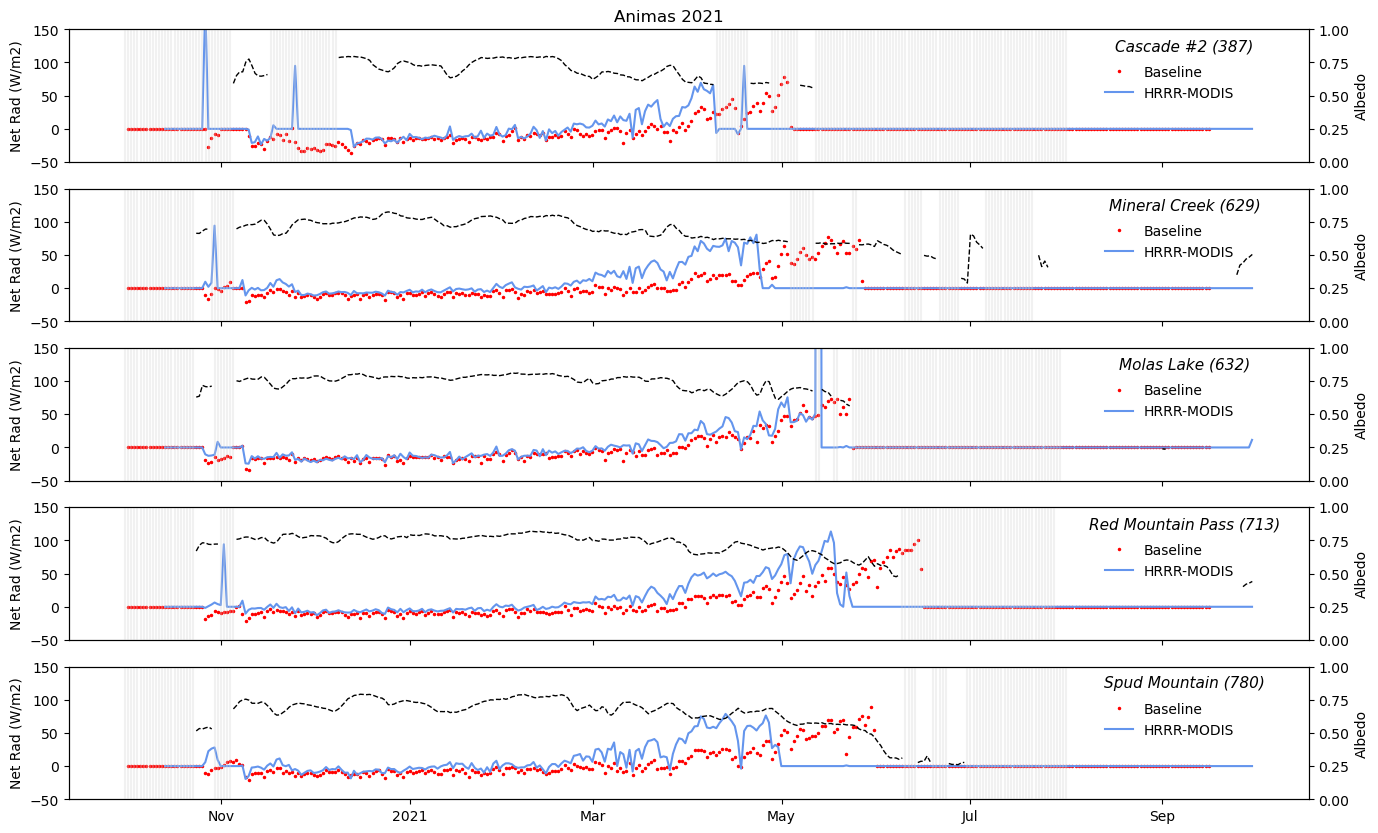

In [11]:
# Make the net_rad and albedo plot
fig, axa = plt.subplots(len(sitenames), 1, figsize=(16, 2 * len(sitenames)), sharey=True, sharex=True)
for jdx, sitename in enumerate(sitenames):
    ax = axa[jdx]
    ds_dict['Baseline_em']['net_rad'][:, jdx, jdx].plot(ax=ax, label='Baseline',
                                                        # color='navy',
                                                        color='r', marker='.', markersize=3, linestyle='None'
                                                        )
    ds_dict['HRRR-MODIS_em']['net_rad'][:, jdx, jdx].plot(ax=ax, label='HRRR-MODIS',
                                                        #   color='dodgerblue',
                                                          color = 'cornflowerblue'
                                                          )
    ax.set_ylim(-50, 150)
    ax2 = ax.twinx()
    # MODIS albedo
    (ds_dict['net_HRRR_MODIS']['albedo'][:, jdx, jdx] / 10000).plot(ax=ax2, color='k', linestyle='--', linewidth=1)
    ax2.set_ylim(0, 1)
    ax2.set_title('')
    ax2.set_ylabel('Albedo')

    # highlight areas where albedo is missing with transparent grey box up till the last 60 days
    albedo_mask = get_missing_albedo_mask(ds_dict['net_HRRR_MODIS']['albedo'][:, jdx, jdx])
    ax2.vlines(x=albedo_mask.index[:-60], ymin=0, ymax=1, color='lightgrey', alpha=0.3)
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('Net Rad (W/m2)')
    ax.annotate(sitename, xy=(0.9, 0.84), xycoords='axes fraction', ha='center', fontsize=11, fontstyle='italic')
    ax.legend(loc='upper right', bbox_to_anchor=(0.95, 0.825), fontsize=10, frameon=False)
plt.suptitle(f'{basin.capitalize()} {WY}', y=0.9)
# plt.tight_layout()

In [12]:
# # Make the net_solar and albedo plot
# fig, axa = plt.subplots(len(sitenames), 1, figsize=(16, 2 * len(sitenames)), sharey=True, sharex=True)
# for jdx, sitename in enumerate(sitenames):
#     ax = axa[jdx]
#     ds_dict['Baseline_em']['net_rad'][:, jdx, jdx].plot(ax=ax, label='Baseline',
#                                                         # color='navy',
#                                                         color='r', marker='.', markersize=3, linestyle='None'
#                                                         )
#     ds_dict['HRRR-MODIS_em']['net_rad'][:, jdx, jdx].plot(ax=ax, label='HRRR-MODIS',
#                                                         #   color='dodgerblue',
#                                                           color = 'cornflowerblue'
#                                                           )
#     ax.set_ylim(-50, 150)
#     ax2 = ax.twinx()
#     # MODIS albedo
#     (ds_dict['net_HRRR_MODIS']['albedo'][:, jdx, jdx] / 10000).plot(ax=ax2, color='k', linestyle='--', linewidth=1)
#     ax2.set_ylim(0, 1)
#     ax2.set_title('')
#     ax2.set_ylabel('Albedo')

#     # highlight areas where albedo is missing with transparent grey box up till the last 60 days
#     albedo_mask = get_missing_albedo_mask(ds_dict['net_HRRR_MODIS']['albedo'][:, jdx, jdx])
#     ax2.vlines(x=albedo_mask.index[:-60], ymin=0, ymax=1, color='lightgrey', alpha=0.3)
#     ax.set_title('')
#     ax.set_xlabel('')
#     ax.set_ylabel('Net Rad (W/m2)')
#     ax.annotate(sitename, xy=(0.9, 0.84), xycoords='axes fraction', ha='center', fontsize=11, fontstyle='italic')
#     ax.legend(loc='upper right', bbox_to_anchor=(0.95, 0.825), fontsize=10, frameon=False)

## Plot raw DSWRF against net_solar DSWRF
- Compare the DSWRF and net solar DSWRF to ensure they are identical at each of the snotel sites

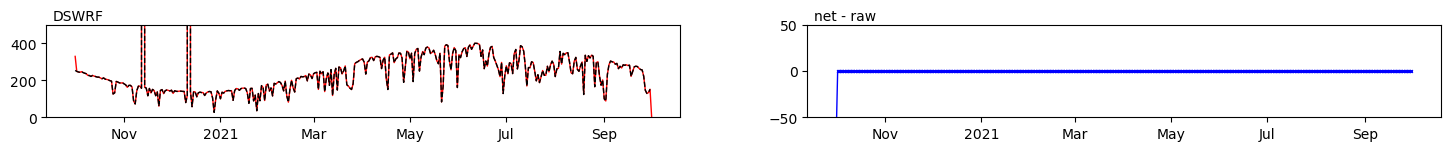

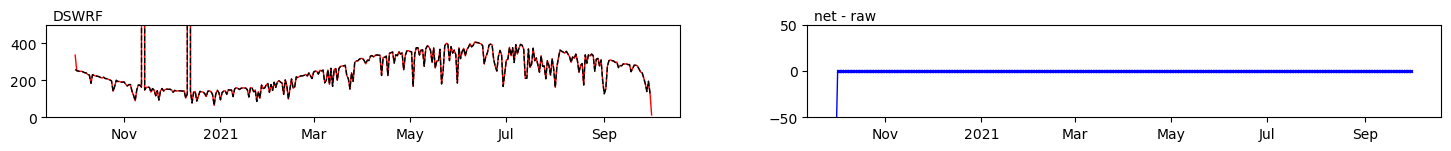

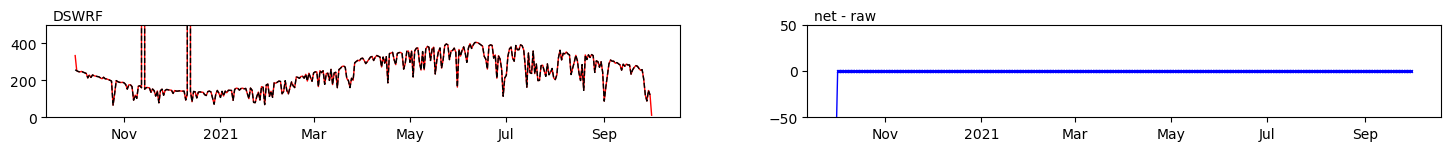

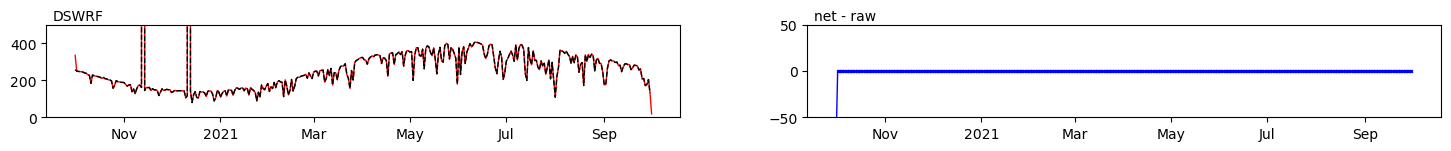

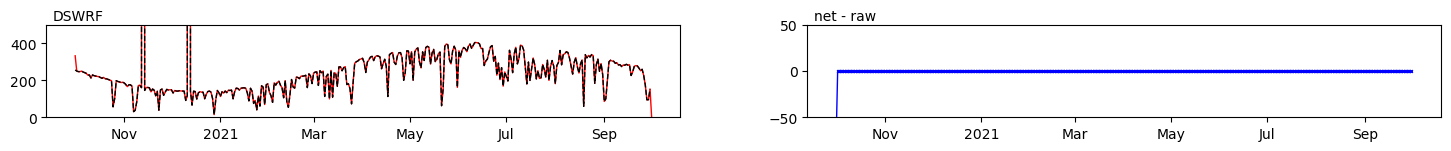

In [13]:
# Plot DSWRF only at each site
data_var = 'DSWRF'
colors = ['r', 'k']
markers = ['x', None]
markersizes = [2, 0]
linewidths = [1,1]
linestyles = ['-', '--']
ylims = 0, 500

for sdx, sitename in enumerate(sitenames):
    fig, axa = plt.subplots(1, 2, figsize=(18,1.2), sharex=True)
    ax = axa[0]
    # Plot the var for the site
    jdx = 0
    ds_dict['DSWRF'][data_var][:, sdx, sdx].plot(ax=ax, label=k, color=colors[jdx],
                                                linewidth=linewidths[jdx], linestyle=linestyles[jdx])
    jdx = 1
    ds_dict['net_HRRR_MODIS'][data_var][:, sdx, sdx].plot(ax=ax, label=k, color=colors[jdx],
                                                linewidth=linewidths[jdx], linestyle=linestyles[jdx])
    ax.annotate(data_var, xy=(0.01, 1.05), xycoords='axes fraction')
    ax = h.prep_axis(ax=ax, turnofflabels=True, ylims=ylims, fc=None)
    ax.set_title('')

    # Plot the difference
    ax = axa[1]
    diff = ds_dict['net_HRRR_MODIS'][data_var][:, sdx, sdx] - ds_dict['DSWRF'][data_var][:, sdx, sdx]
    diff.plot(ax=ax, color='blue', marker='x', markersize=2, linewidth=1, linestyle='-')
    ax.annotate('net - raw', xy=(0.01, 1.05), xycoords='axes fraction')
    ax = h.prep_axis(ax=ax, turnofflabels=True, ylims=(-50, 50), fc=None)
    ax.set_title('')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# # Add more ticks
# ax.minorticks_on()
# ax.grid(color='lightgrey', linewidth=0.3, which='both')
# plt.suptitle(f'{basin} WY {WY} SNOTEL site {sitename}')
# plt.tight_layout()

<xarray.DataArray 'time' ()> Size: 8B
array('2020-10-13T22:00:00.000000000', dtype='datetime64[ns]') <xarray.DataArray 'time' ()> Size: 8B
array('2021-09-15T22:00:00.000000000', dtype='datetime64[ns]')


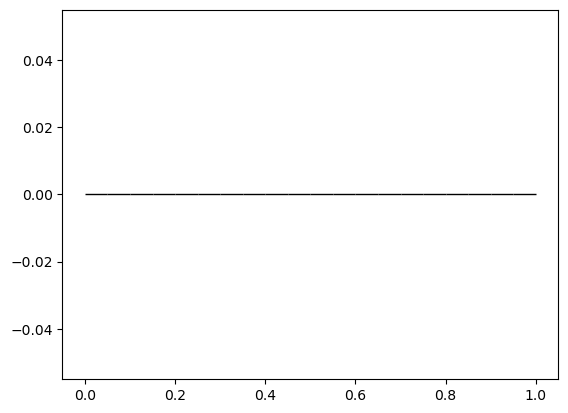

In [14]:
# and check the difference element-wise for all the sites
# element_diff = ds_dict['net_HRRR_MODIS'][data_var][:, sdx, sdx] - ds_dict['DSWRF'][data_var][:, sdx, sdx]
# element_diff[element_diff != 0]

# Trim to the same time period
def trim_to_common_time(ds_dict):
    # Get the common time range
    time_start = max([ds.time.min() for ds in ds_dict.values()])
    time_end = min([ds.time.max() for ds in ds_dict.values()])
    print(time_start, time_end)
    # Trim each dataset to the common time range
    for k, ds in ds_dict.items():
        ds_dict[k] = ds.sel(time=slice(time_start, time_end))
    return ds_dict

ds_dict = trim_to_common_time(ds_dict)
element_diff = ds_dict['net_HRRR_MODIS'][data_var].values - ds_dict['DSWRF'][data_var].values

plt.hist(element_diff[element_diff != 0], bins=20, ec='k');


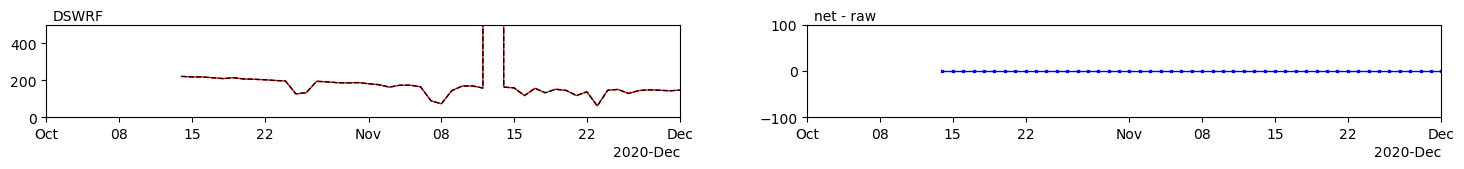

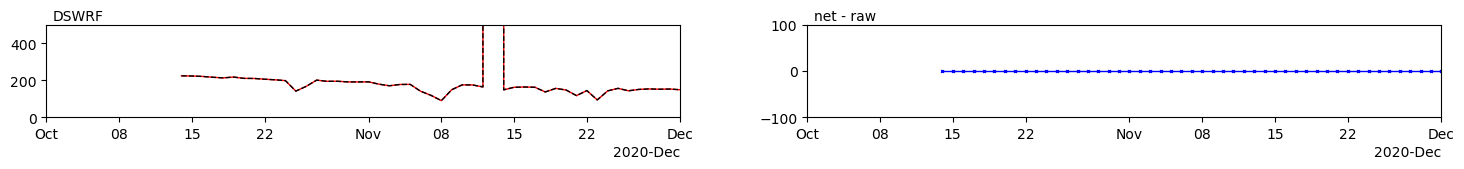

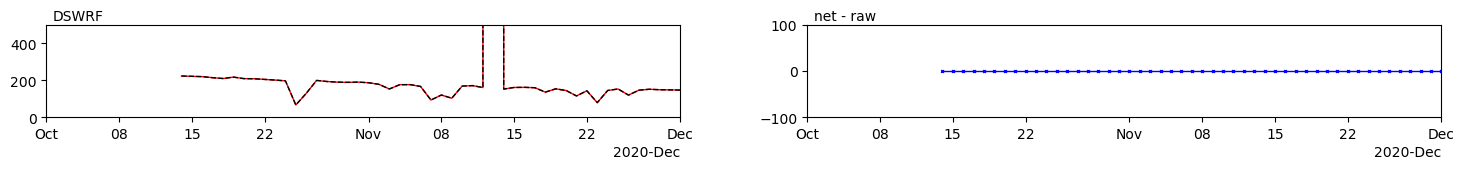

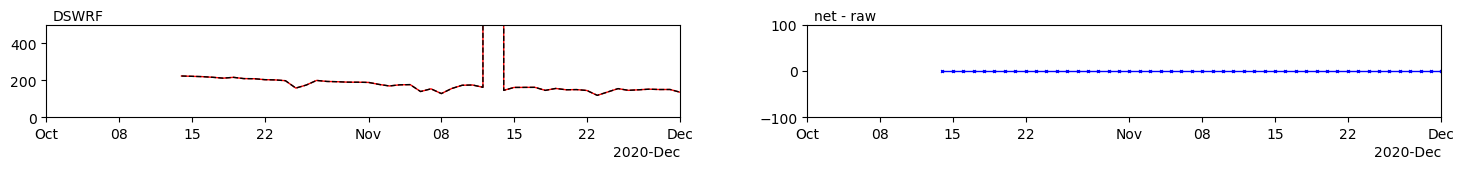

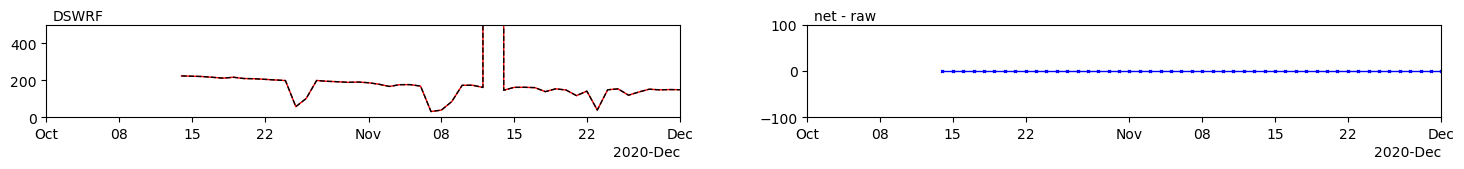

In [15]:
# Zoom into the first 30 days
# Plot DSWRF only at each site
data_var = 'DSWRF'
for sdx, sitename in enumerate(sitenames):
    fig, axa = plt.subplots(1, 2, figsize=(18,1.2), sharex=True)
    ax = axa[0]
    # Plot the var for the site
    jdx = 0
    ds_dict['DSWRF'][data_var][:, sdx, sdx].plot(ax=ax, label=k, color=colors[jdx],
                                                linewidth=linewidths[jdx], linestyle=linestyles[jdx])
    jdx = 1
    ds_dict['net_HRRR_MODIS'][data_var][:, sdx, sdx].plot(ax=ax, label=k, color=colors[jdx],
                                                linewidth=linewidths[jdx], linestyle=linestyles[jdx])
    ax.annotate(data_var, xy=(0.01, 1.05), xycoords='axes fraction')
    ax = h.prep_axis(ax=ax, turnofflabels=True, ylims=ylims, fc=None)
    ax.set_title('')

    # Plot the difference
    ax = axa[1]
    diff = ds_dict['net_HRRR_MODIS'][data_var][:, sdx, sdx] - ds_dict['DSWRF'][data_var][:, sdx, sdx]
    diff.plot(ax=ax, color='blue', marker='x', markersize=2, linewidth=1, linestyle='-')
    ax.annotate('net - raw', xy=(0.01, 1.05), xycoords='axes fraction')
    ax = h.prep_axis(ax=ax, turnofflabels=True, ylims=(-100, 100), fc=None)
    ax.set_title('')
    ax.set_xlim(pd.Timestamp(f'{WY-1}-10-01'), pd.Timestamp(f'{WY-1}-12-01'))

## Now see how missing albedo values affects net solar values

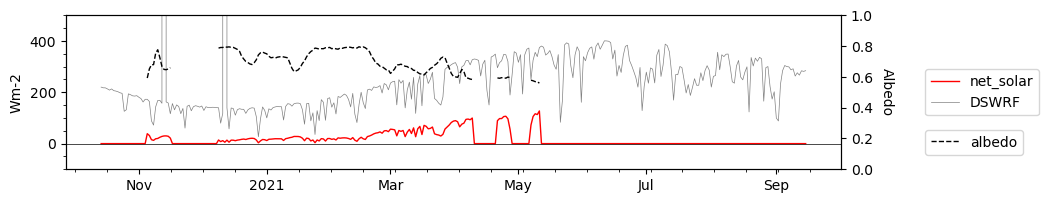

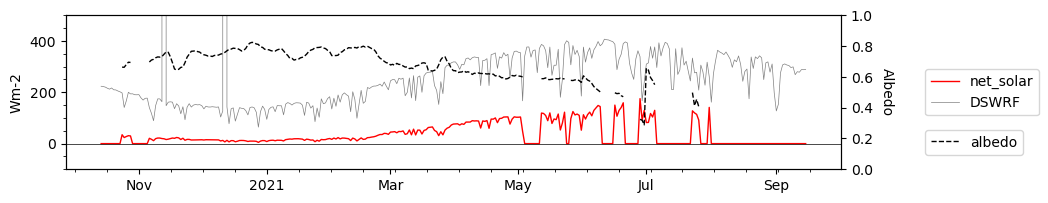

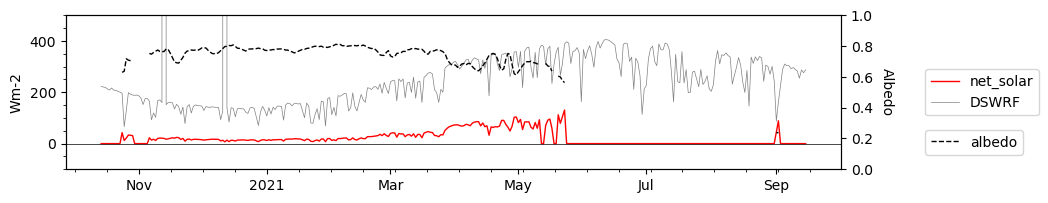

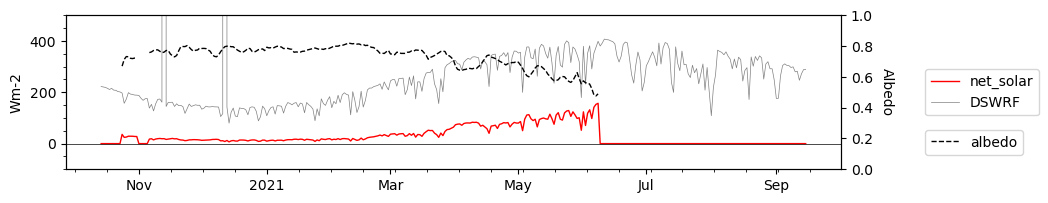

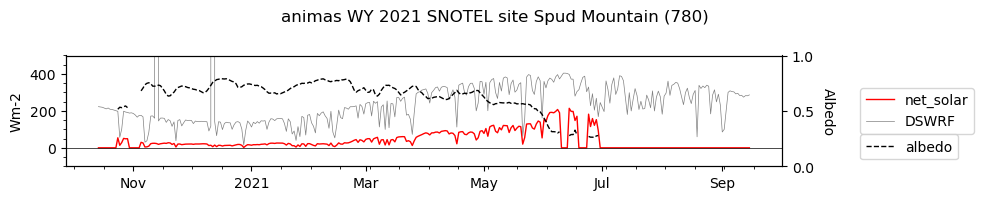

In [16]:
# Loop through sites
ylims = -100, 500
for sdx, sitename in enumerate(sitenames):
    fig, ax = plt.subplots(1, 1, figsize=(10,2), sharex=True, sharey=True)
    # Plot net solar
    data_var = 'net_solar'
    ds_dict['net_HRRR_MODIS'][data_var][:, sdx, sdx].plot(ax=ax, label=data_var, color='red', linewidth=1, linestyle='-')
    # Plot DSWRF
    data_var = 'DSWRF'
    ds_dict['net_HRRR_MODIS'][data_var][:, sdx, sdx].plot(ax=ax, label=data_var, color='gray', linewidth=0.5, linestyle='-')
    ax.set_ylim(ylims)
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('Wm-2')

    # Plot the albedo on the second axis
    ax2 = ax.twinx()
    data_var = 'albedo'
    (ds_dict['net_HRRR_MODIS'][data_var][:, sdx, sdx] / 10000).plot(ax=ax2, label=data_var, color = 'k', linewidth=1, linestyle='--')
    ax2.set_ylabel('Albedo', rotation=270, labelpad=15)
    ax2.set_title('')
    ax2.set_ylim(0, 1)
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
    ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.175))
    # Add more ticks
    ax.minorticks_on()

    # Add a zero line for net solar
    ax.axhline(0, color='black', linewidth=0.5)

plt.suptitle(f'{basin} WY {WY} SNOTEL site {sitename}')
plt.tight_layout()

When albedo is missing net solar is not calculated and goes to zero (as seen previously) under the assumption that there is no snow. But what if the thickness disagrees with tha? 

In [17]:
ds_dict.keys()

dict_keys(['DSWRF', 'Baseline_em', 'Baseline_smrf_2', 'Baseline_smrf_energy_balance', 'Baseline_snow', 'HRRR-MODIS_em', 'HRRR-MODIS_smrf_2', 'HRRR-MODIS_snow', 'net_HRRR_MODIS'])

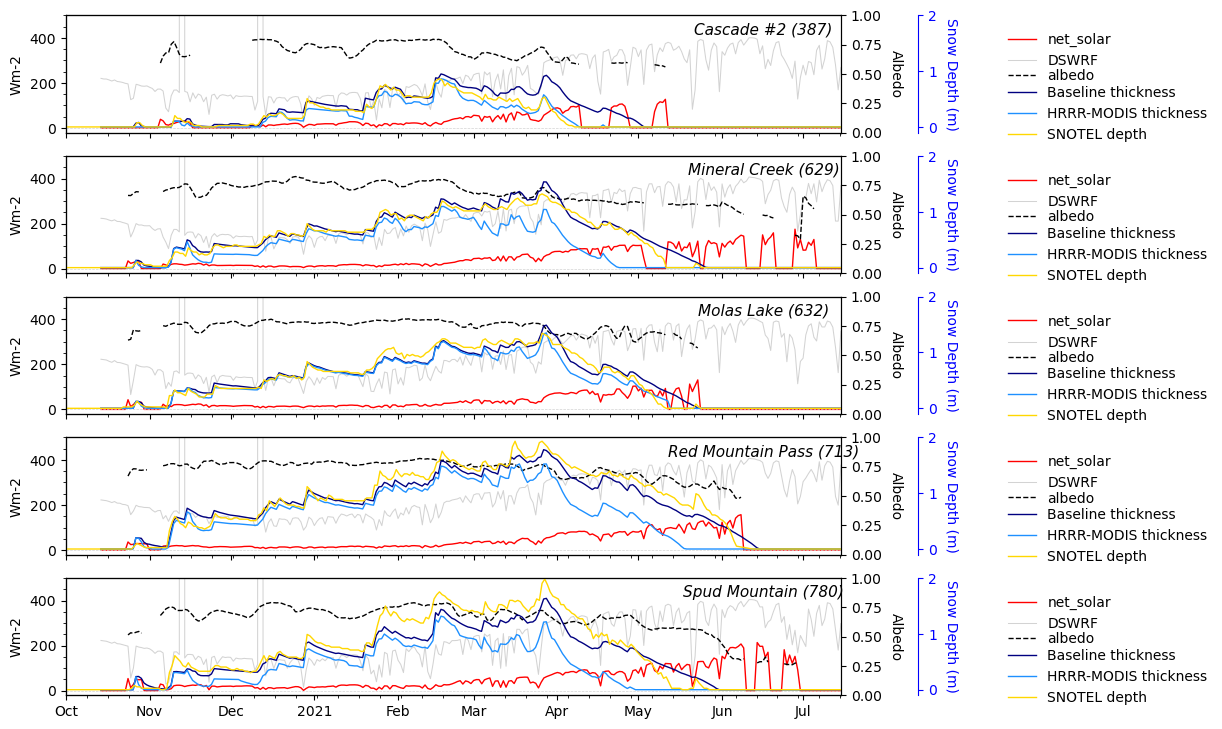

In [20]:
# Plot hrrr-modis snow depth on top of albedo, net solar, net_radiation, and DSWRF
# Loop through sites
ylims = -20, 500
fig, axa = plt.subplots(1*len(sitenames), 1, figsize=(10,2*len(sitenames)), sharex=True, sharey=True)
for sdx, sitename in enumerate(sitenames):
    ax = axa[sdx]
    # fig, ax = plt.subplots(1, 1, figsize=(10,2), sharex=True, sharey=True)

    # Plot net solar
    data_var = 'net_solar'
    ds_dict['net_HRRR_MODIS'][data_var][:, sdx, sdx].plot(ax=ax, label=data_var, color='red', linewidth=1, linestyle='-')

    # Plot DSWRF
    data_var = 'DSWRF'
    ds_dict['net_HRRR_MODIS'][data_var][:, sdx, sdx].plot(ax=ax, label=data_var, color='lightgrey', linewidth=0.75, linestyle='-')
    ax = h.prep_axis(ax=ax, ylims=ylims, fc=None, xlab='', ylab='Wm-2')
    ax.set_title('')
    ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.7), frameon=False)

    # Plot the albedo on the second axis
    ax2 = ax.twinx()
    data_var = 'albedo'
    (ds_dict['net_HRRR_MODIS'][data_var][:, sdx, sdx] / 10000).plot(ax=ax2, label=data_var, color = 'k', linewidth=1, linestyle='--')
    ax2.set_ylabel('Albedo', rotation=270, labelpad=15)
    ax2.set_ylim(0, 1)
    ax2.set_title('')
    ax2.legend(loc='center left', bbox_to_anchor=(1.2, 0.48), frameon=False)

    # Plot the HRRR-MODIS snow depth on a third axis
    ax3 = ax.twinx()
    data_var = 'thickness'
    ds_dict['Baseline_snow'][data_var][:, sdx, sdx].plot(ax=ax3, label='Baseline thickness', color='navy', linewidth=1, linestyle='-')
    ds_dict['HRRR-MODIS_snow'][data_var][:, sdx, sdx].plot(ax=ax3, label='HRRR-MODIS thickness', color='dodgerblue', linewidth=1, linestyle='-')

    # Plot the SNOTEL depth on top
    snotel_dfs[sitename]['SNOWDEPTH_m'].plot(ax=ax3, label='SNOTEL depth', color='gold', linewidth=1)

    ax3.legend(loc='center left', bbox_to_anchor=(1.2, 0.16), frameon=False)
    ax3.set_ylabel('Snow Depth (m)', rotation=270, labelpad=15, color='blue')
    ax3.set_ylim(-0.1, 2)
    ax3.set_title('')
    # offset the axis spine
    ax3.spines['right'].set_position(('axes', 1.1))

    # Change to the same color as the snow depth
    ax3.spines['right'].set_color('blue')
    # Change tick and ticklabels to the same color
    ax3.tick_params(axis='y', colors='blue')

    # Add more ticks
    ax.minorticks_on()

    # Add a zero line for net solar
    ax.axhline(0, color='lightgray', linewidth=0.5, linestyle='--')

    # Trim everything to August
    ax.set_xlim(pd.Timestamp(f'{WY-1}-10-01'), pd.Timestamp(f'{WY}-7-15'))

    ax.set_xlabel('')
    ax.annotate(sitename, xy=(0.9, 0.84), xycoords='axes fraction', ha='center', fontsize=11, fontstyle='italic')

In [21]:
# del all the datasets
# del allsites_fn, ax, ax2, axa, diff, ds, ds_dict, extract_fns, extract_name, extract_names, f, fig, found_sites, jdx, k, linestyles, linewidths, markers, markersizes, miniconda_dir
del allsites_fn, ax, ax2, axa, diff, ds, extract_fns, extract_name, f, fig, found_sites, jdx, k, linestyles, linewidths, markers, markersizes, miniconda_dir

In [22]:
del poly_fn, proj_version, pyprojdatadir, sdx, sitename, snotel_dfs, snotel_dir, snotel_metadf, ST_arr

In [23]:
# # Maybe there's something wrong with the precision. What is the precision of the data?
# for k in ds_dict.keys():
#     print(k)
#     print(ds_dict[k].encoding)
#     for v in ds_dict[k].data_vars:
#         print(v, ds_dict[k][v].dtype)
#     print('---')

Float32 will only allow for 7 digits of precision, when we're calculating net radiation, we are using the Stefan-Boltmann constant.  
This constant is 5.67e-8, which requires 8 digits of precision. We should be using Float64.

In [24]:
import copy

In [25]:
def calc_net_longwave(I_lw, T_s_0):
    """
    Calculate the net longwave radiation from the incoming longwave radiation and surface temperature
    """
    SNOW_EMISSIVITY = 0.98
    STEFAN_BOLTZMANN = 5.67032e-8
    KELVINCONVERSION = 273.16

    # Calculate the net longwave radiation
    net_longwave = SNOW_EMISSIVITY * (I_lw - STEFAN_BOLTZMANN * (T_s_0 + KELVINCONVERSION) ** 4)

    net_longwave.attrs = copy.deepcopy(I_lw.attrs)
    net_longwave.attrs['long_name'] = 'net longwave radiation'
    net_longwave.attrs['module'] = None

    return net_longwave

In [26]:
# Calculate net_LW with float32 precision
net_lw32 = calc_net_longwave(ds_dict['HRRR-MODIS_smrf_2']['thermal'], ds_dict['HRRR-MODIS_snow']['temp_surf'])
net_lw32.values.dtype

dtype('float32')

In [27]:
# Extract variables for net_lw calculation
# Coerce to float64
# Pull T_s_0 from snow (this is in Celsius)
T_s_0 = ds_dict['HRRR-MODIS_snow']['temp_surf']
T_s_0 = T_s_0.astype(np.float64)

# Pull I_lw from thermal in smrf_2
I_lw = ds_dict['HRRR-MODIS_smrf_2']['thermal']
I_lw = I_lw.astype(np.float64)

# Calculate net_LW with float64 precision
net_lw64 = calc_net_longwave(I_lw, T_s_0)

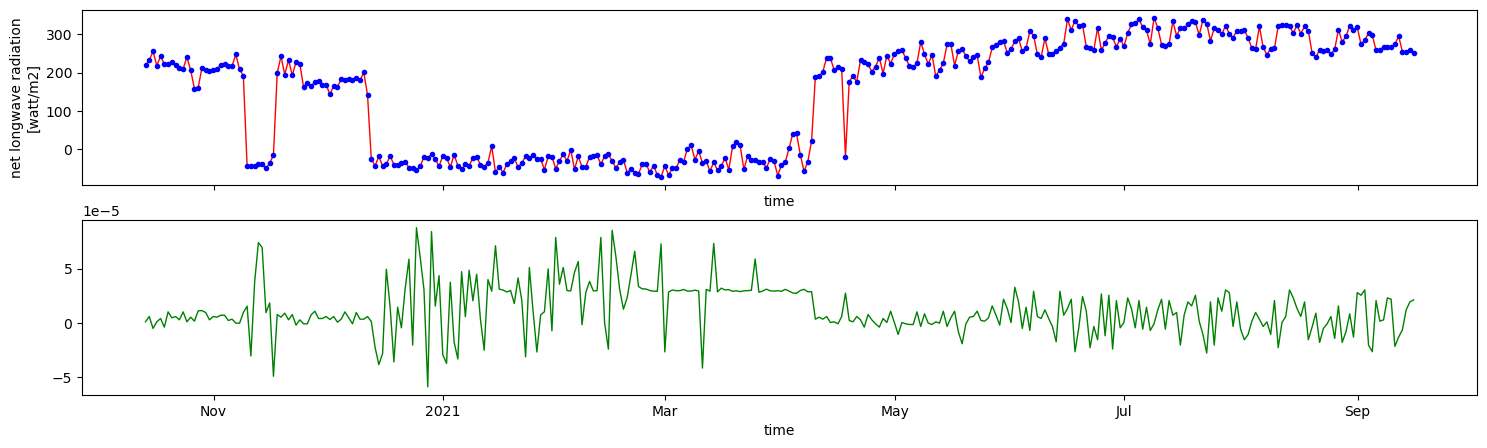

In [28]:
# Plot the two and the difference
fig, axa = plt.subplots(2, 1, figsize=(18,5), sharex=True)
sdx = 0
net_lw32[:, sdx, sdx].plot(ax=axa[0], label='net_lw32', color='red', linewidth=1, linestyle='-')
net_lw64[:, sdx, sdx].plot(ax=axa[0], label='net_lw64', color='blue', marker='.', linewidth=0, linestyle='-')
diff = net_lw64[:, sdx, sdx] - net_lw32[:, sdx, sdx]
diff.plot(ax=axa[1], label='diff', color='green', linewidth=1, linestyle='-')
for ax in axa.flatten():
    ax.set_title('')


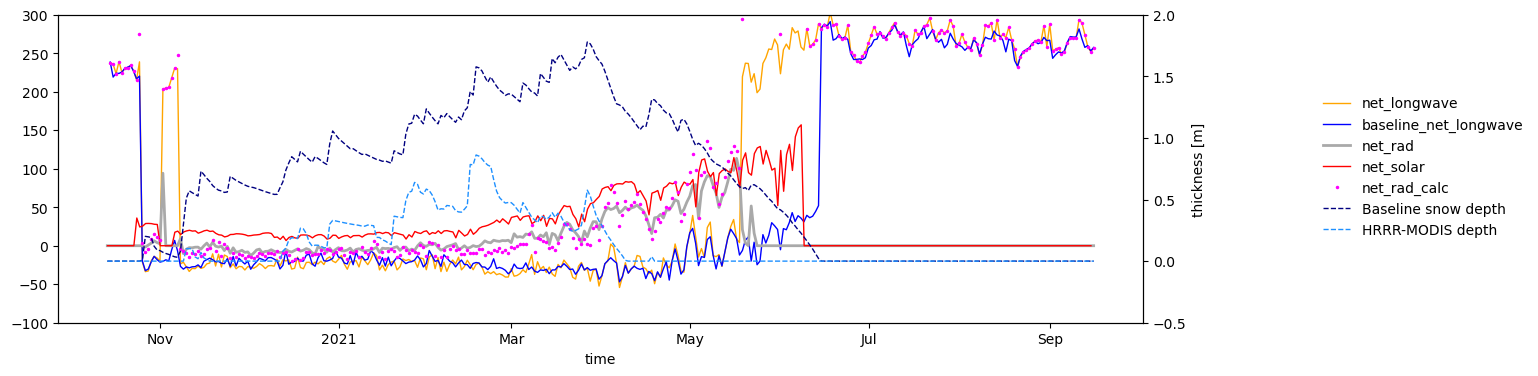

In [30]:
# Plot T_s_0 and I_lw and calculated net_longwave
# Derive net_longwave from I_lw and T_s_0
net_longwave = calc_net_longwave(I_lw, T_s_0)
baseline_net_lw = calc_net_longwave(ds_dict['Baseline_smrf_2']['thermal'], ds_dict['Baseline_snow']['temp_surf'])

# Trim to the same extents as net_solar
net_rad = ds_dict['HRRR-MODIS_em']['net_rad']
net_solar = ds_dict['net_HRRR_MODIS']['net_solar']
net_longwave = net_longwave.sel(time=slice(net_solar.time.min(), net_rad.time.max()))
baseline_net_lw = baseline_net_lw.sel(time=slice(net_solar.time.min(), net_rad.time.max()))

sdx = 3
fig, ax = plt.subplots(1, 1, figsize=(14,4), sharex=True, sharey=True)

# Plot net longwave
net_longwave[:, sdx, sdx].plot(label='net_longwave', color='orange', linewidth=1, linestyle='-')
baseline_net_lw[:, sdx, sdx].plot(label='baseline_net_longwave', color='blue', linewidth=1, linestyle='-')
# ylims = ax.get_ylim()
ax.set_title('')

# Plot net radiation
net_rad[:, sdx, sdx].plot(label='net_rad', color='darkgrey', linewidth=2, linestyle='-')
ylims = (-100, 300)
ax.set_ylim(ylims)
ax.set_title('')

# Plot net solar
net_solar[:, sdx, sdx].plot(label='net_solar', color='r', linewidth=1, linestyle='-')
ax.set_title('')
# Plot the combined net longwave and net solar that should equal net radiation

# Increase all net_solar values by 22 hours
net_solar = net_solar.assign_coords(time=net_solar.time + pd.Timedelta(hours=22))

# Coerce net solar x and y coords to float32
net_solar['x'] = net_solar['x'].astype(np.float32)
net_solar['y'] = net_solar['y'].astype(np.float32)

# Calculate net radiation from net longwave and net solar
calc_net_rad = copy.deepcopy(net_longwave)
calc_net_rad = calc_net_rad + net_solar
calc_net_rad = calc_net_rad.astype(np.float64)
calc_net_rad[:, sdx, sdx].plot(label='net_rad_calc', color='magenta', marker='.', markersize=3, linewidth=0, linestyle='-')
ax.set_title('')

# Plot snow depth on top
ax2= ax.twinx()
ds_dict['Baseline_snow']['thickness'][:, sdx, sdx].plot(ax=ax2, label='Baseline snow depth', color='navy', linewidth=1, linestyle='--')
ds_dict['HRRR-MODIS_snow']['thickness'][:, 0, 0].plot(ax=ax2, label='HRRR-MODIS depth', color='dodgerblue', linewidth=1, linestyle='--')
ax2.set_title('')
ax2.set_ylim(-0.5, 2)
# See if net_longwave + net_solar = net_rad
fig.legend(bbox_to_anchor=(1.1, 0.5), loc='center', fontsize=10, frameon=False)

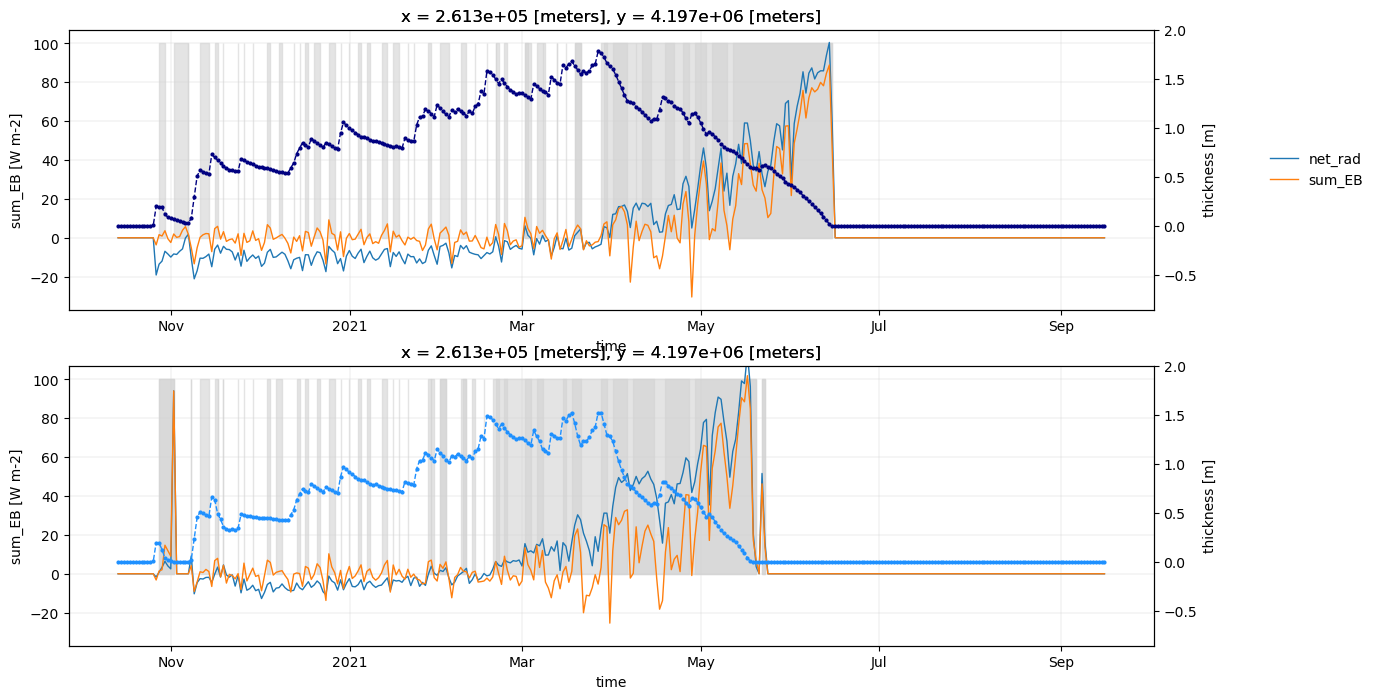

In [31]:
fig, axa = plt.subplots(2, 1, figsize=(14,8))
ax = axa[0]
for v in ds_dict['Baseline_em'].data_vars:
    if v not in ['sensible_heat', 'snow_soil', 'precip_advected', 'latent_heat', 'evaporation', 'snowmelt', 'SWI', 'cold_content']:
        # plot on the same plot
        ax = axa[0]
        ds_dict['Baseline_em'][v][:, sdx, sdx].plot(ax=ax, label=v, linewidth=1, linestyle='-')
        # highlight where data_vars are positive
        ax.fill_between(ds_dict['Baseline_em'].time, 100, 0, where=ds_dict['Baseline_em'][v][:, sdx, sdx] > 0, color='lightgrey', alpha=0.6)
        ylims = ax.get_ylim()
        ax = axa[1]
        ds_dict['HRRR-MODIS_em'][v][:, sdx, sdx].plot(ax=ax, label=v, linewidth=1, linestyle='-')
        ax.fill_between(ds_dict['HRRR-MODIS_em'].time, 100, 0, where=ds_dict['HRRR-MODIS_em'][v][:, sdx, sdx] > 0, color='lightgrey', alpha=0.6)
        ax.set_ylim(ylims)
# Plot snow depth on top
ax = axa[0]
ax.grid(color='lightgrey', linewidth=0.3, which='both')
ax2 = ax.twinx()
ds_dict['Baseline_snow']['thickness'][:, sdx, sdx].plot(ax=ax2, label='Baseline snow depth', marker='o', markersize=2, color='navy', linewidth=1, linestyle='--')
ax2.set_ylim(-0.85, 2)
ax = axa[1]
ax.grid(color='lightgrey', linewidth=0.3, which='both')
ax2 = ax.twinx()
ds_dict['HRRR-MODIS_snow']['thickness'][:, sdx, sdx].plot(ax=ax2, label='HRRR-MODIS depth', marker='o', markersize=2, color='dodgerblue', linewidth=1, linestyle='--')
ax2.set_ylim(-0.85, 2)
axa[0].legend(frameon=False, bbox_to_anchor=(1.15, 0.5), loc='center', fontsize=10)



Text(0.5, 1.0, '')

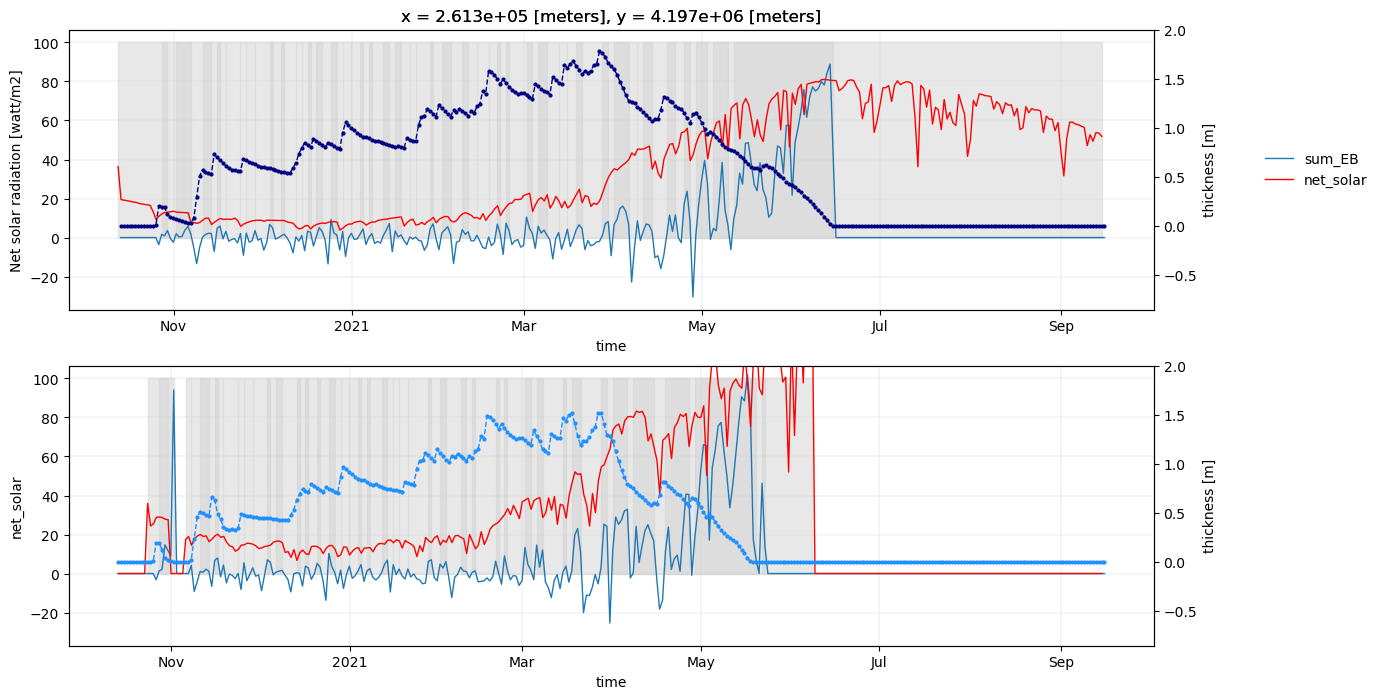

In [35]:
# Plot the same thing as above, but with net solar instead of net radiation
fig, axa = plt.subplots(2, 1, figsize=(14,8))
alpha = 0.5
ax = axa[0]
drop_vars = ['net_rad', 'sensible_heat', 'snow_soil', 'precip_advected', 'latent_heat', 'evaporation', 'snowmelt', 'SWI', 'cold_content']
# drop_vars = ['sensible_heat', 'snow_soil', 'precip_advected', 'latent_heat', 'evaporation', 'snowmelt', 'SWI', 'cold_content']
for v in ds_dict['Baseline_em'].data_vars:
    if v not in drop_vars:
        # plot on the same plot
        ax = axa[0]
        ds_dict['Baseline_em'][v][:, sdx, sdx].plot(ax=ax, label=v, linewidth=1, linestyle='-')
        # highlight where data_vars are positive
        ax.fill_between(ds_dict['Baseline_em'].time, 100, 0, where=ds_dict['Baseline_em'][v][:, sdx, sdx] > 0, color='lightgrey', alpha=alpha)
        ylims = ax.get_ylim()
        ax.set_ylim(ylims)
        ax = axa[1]
        ds_dict['HRRR-MODIS_em'][v][:, sdx, sdx].plot(ax=ax, label=v, linewidth=1, linestyle='-')
        ax.fill_between(ds_dict['HRRR-MODIS_em'].time, 100, 0, where=ds_dict['HRRR-MODIS_em'][v][:, sdx, sdx] > 0, color='lightgrey', alpha=alpha)
        ax.set_ylim(ylims)
# Also plot net solar
ax = axa[0]
ds_dict['Baseline_smrf_energy_balance']['net_solar'][:, sdx, sdx].resample(time='1D').mean().plot(ax=ax, label='net_solar', color='red', linewidth=1, linestyle='-')
ax.fill_between(ds_dict['Baseline_smrf_energy_balance'].resample(time='1D').mean().time, 100, 0, where=ds_dict['Baseline_smrf_energy_balance']['net_solar'][:, sdx, sdx].resample(time='1D').mean() > 0, color='lightgrey', alpha=alpha)
ax = axa[1]
ds_dict['net_HRRR_MODIS']['net_solar'][:, sdx, sdx].plot(ax=ax, label='net_solar', color='red', linewidth=1, linestyle='-')
ax.fill_between(ds_dict['net_HRRR_MODIS'].time, 100, 0, where=ds_dict['net_HRRR_MODIS']['net_solar'][:, sdx, sdx] > 0, color='lightgrey', alpha=alpha)

# Plot snow depth on top
ax = axa[0]
ax.grid(color='lightgrey', linewidth=0.3, which='both')
ax2 = ax.twinx()
ds_dict['Baseline_snow']['thickness'][:, sdx, sdx].plot(ax=ax2, label='Baseline snow depth', marker='o', markersize=2, color='navy', linewidth=1, linestyle='--')
ax2.set_ylim(-0.85, 2)
ax = axa[1]
ax.grid(color='lightgrey', linewidth=0.3, which='both')
ax.set_title('')
ax2 = ax.twinx()
ds_dict['HRRR-MODIS_snow']['thickness'][:, sdx, sdx].plot(ax=ax2, label='HRRR-MODIS depth', marker='o', markersize=2, color='dodgerblue', linewidth=1, linestyle='--')
ax2.set_ylim(-0.85, 2)
axa[0].legend(frameon=False, bbox_to_anchor=(1.15, 0.5), loc='center', fontsize=10)
ax2.set_title('')


# TODO: Clean up everything above to present clearly tomorrow!

- snow depth + net radiation + sumEB (HRRR-MODIS)
- snow depth + net radiation + sumEB (Baseline)
  
- snow depth + net solar + sumEB (HRRR-MODIS)
- snow depth + net solar + sumEB (Baseline)
  
- snow depth + net solar + net longwave (HRRR-MODIS)
- snow depth + net solar + net longwave (Baseline)
  
- snow depths + net solars + net longwaves (single plot)

- snow depths + calculated net radiations + net radiations (single plot)


Under what circumstances does net radiation grow exponentially?
- when net solar is gigantic and positive (we are not seeing this)
- when net longwave is gigantic and negative

(np.float64(18536.0), np.float64(18597.0))

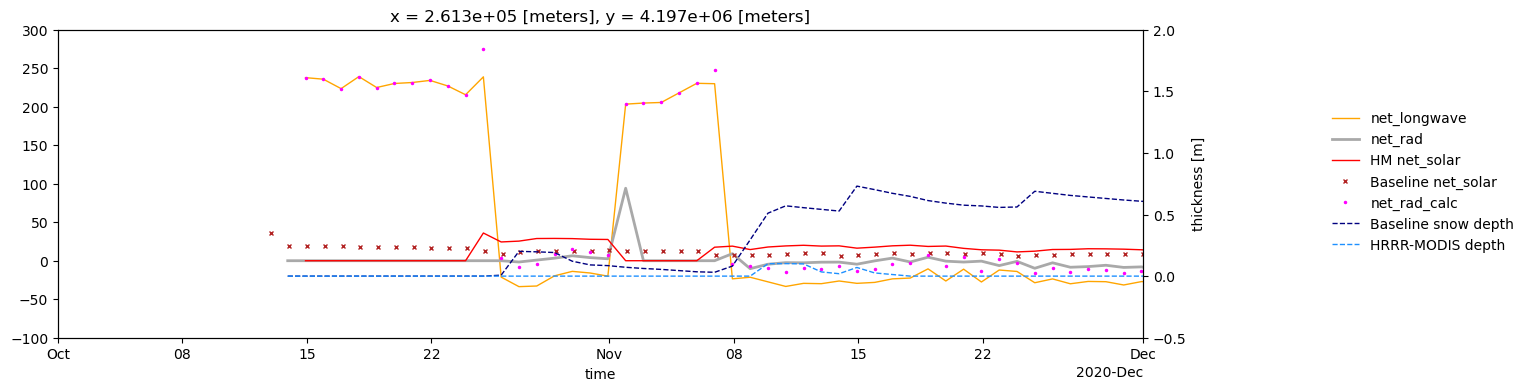

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(14,4), sharex=True, sharey=True)
# Plot net longwave
net_longwave[:, sdx, sdx].plot(label='net_longwave', color='orange', linewidth=1, linestyle='-')
ax.set_title('')

# Plot net radiation
net_rad[:, sdx, sdx].plot(label='net_rad', color='darkgrey', linewidth=2, linestyle='-')
ylims = (-100, 300)
ax.set_ylim(ylims)
ax.set_title('')

# Plot net solar
net_solar[:, sdx, sdx].plot(label='HM net_solar', color='r', linewidth=1, linestyle='-')
ds_dict['Baseline_smrf_energy_balance']['net_solar'].resample(time='1D').mean()[:, sdx, sdx].plot(label='Baseline net_solar', color='firebrick', marker='x', markersize=3, linewidth=0, linestyle='-')
ax.set_title('')

# Plot the combined net longwave and net solar that should equal net radiation
# Increase all net_solar values by 22 hours
net_solar = net_solar.assign_coords(time=net_solar.time + pd.Timedelta(hours=22))

# Coerce net solar x and y coords to float32
net_solar['x'] = net_solar['x'].astype(np.float32)
net_solar['y'] = net_solar['y'].astype(np.float32)

# Calculate net radiation from net longwave and net solar
calc_net_rad[:, sdx, sdx].plot(label='net_rad_calc', color='magenta', marker='.', markersize=3, linewidth=0, linestyle='-')

# Plot snow depth on top
ax2= ax.twinx()
ds_dict['Baseline_snow']['thickness'][:, sdx, sdx].plot(ax=ax2, label='Baseline snow depth', color='navy', linewidth=1, linestyle='--')
ds_dict['HRRR-MODIS_snow']['thickness'][:, 0, 0].plot(ax=ax2, label='HRRR-MODIS depth', color='dodgerblue', linewidth=1, linestyle='--')
ax2.set_title('')
ax2.set_ylim(-0.5, 2)
# See if net_longwave + net_solar = net_rad
fig.legend(bbox_to_anchor=(1.1, 0.5), loc='center', fontsize=10, frameon=False)

# Zoom to early season
ax.set_xlim(pd.Timestamp(f'{WY-1}-10-01'), pd.Timestamp(f'{WY-1}-12-01'))

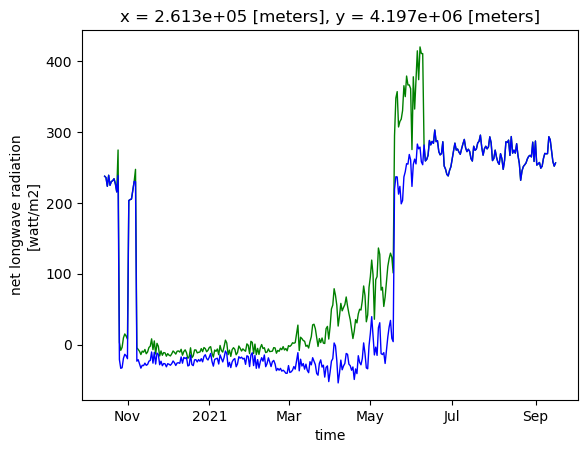

In [37]:
# Plot clac_net_rad and netlongav
calc_net_rad[:, sdx, sdx].plot(label='net_rad_calc', color='green', linewidth=1, linestyle='-')
net_longwave[:, sdx, sdx].plot(label='net_longwave', color='blue', linewidth=1, linestyle='-')

TypeError: No numeric data to plot.

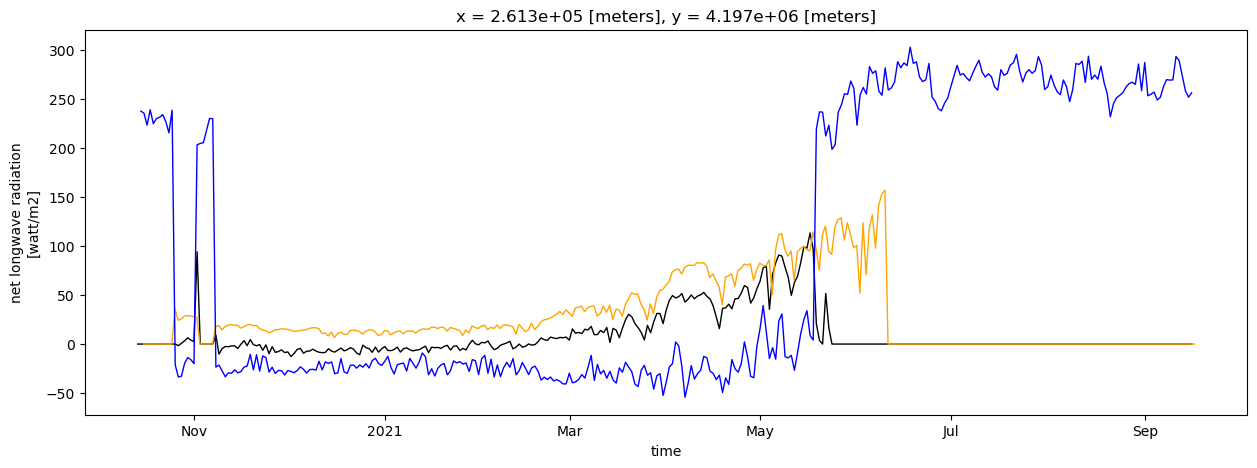

In [38]:
# Plot net rad, net_rad_calc, net_solar and net_longwave only
fig, ax = plt.subplots(1, 1, figsize=(15,5), sharex=True, sharey=True)
# Net Rad
net_rad[:, sdx, sdx].plot(label='net_rad', color='k', linewidth=1, linestyle='-')
# # Net Rad calc
# calc_net_rad[:, sdx, sdx].plot(label='net_rad_calc', color='green', linewidth=1, linestyle='-')
# Net solar
net_solar[:, sdx, sdx].plot(label='net_solar', color='orange', linewidth=1, linestyle='-')
# Net longwave
net_longwave[:, sdx, sdx].plot(label='net_longwave', color='blue', linewidth=1, linestyle='-')

# Calculated net longwave
calc_net_longwave = copy.deepcopy(net_rad)
calc_net_longwave = calc_net_longwave - net_solar
calc_net_longwave[:, sdx, sdx].plot(label='net_longwave_calc', color='green', linewidth=1, linestyle='-')
ax.set_ylim(-100, 300)
fig.legend(bbox_to_anchor=(0.5, 0.5), loc='center', fontsize=10, frameon=False)


In [39]:
# TODO: PICK UP FROM HERE
# Plot the bits for the animas year over year to see what is different
# Questions to answer:
# - is DSWRF super different from one year to the next? (I think they should be similar) what about the spikes?
# - is the missing albedo different from one year to the next and does that correspond with snow depth?
# - is the net solar different from one year to the next and does that correspond with snow depth? -- running extract for animas now


In [40]:
# Load the files anew
dswrf_list = [xr.open_dataset(f).resample(time='1D').mean() for f in h.fn_list(workdir, f'DSWRF*{basin}*')]
em_list = [xr.open_dataset(f) for f in h.fn_list(workdir, f'*{basin}*em*')]
hm_netsolar_list= [xr.open_dataset(f).resample(time='1D').mean() for f in h.fn_list(workdir, f'net_HRRR_MODIS*{basin}*_snotel.nc')]
baseline_netsolar_list = [xr.open_dataset(f).resample(time='1D').mean() for f in h.fn_list(workdir, f'*{basin}*smrf_energy_balance*')] # make sure this is extracted separately for plotting
print(len(dswrf_list), len(em_list), len(hm_netsolar_list), len(baseline_netsolar_list))

3 7 3 3


In [41]:
import seaborn as sns
sns.set_palette('icefire')

# you don't have to loop to plot like this, but it is easier to see the delineations for each water year

DSWRF
net_rad
net_solar


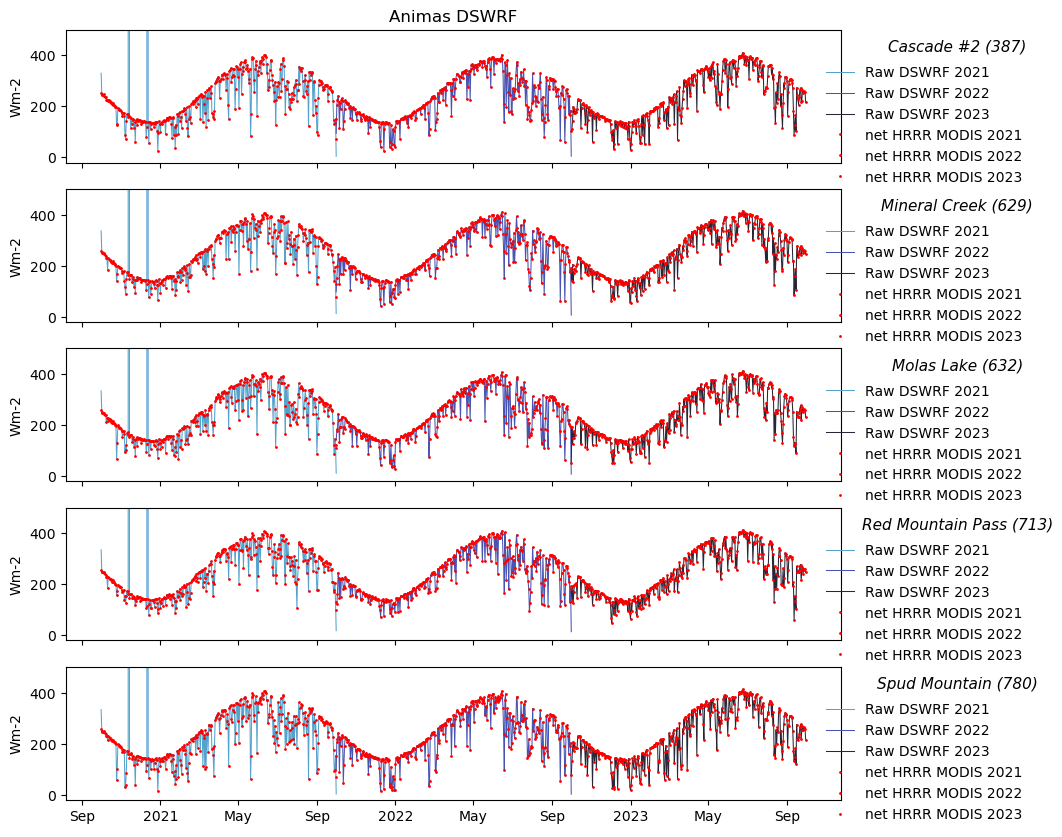

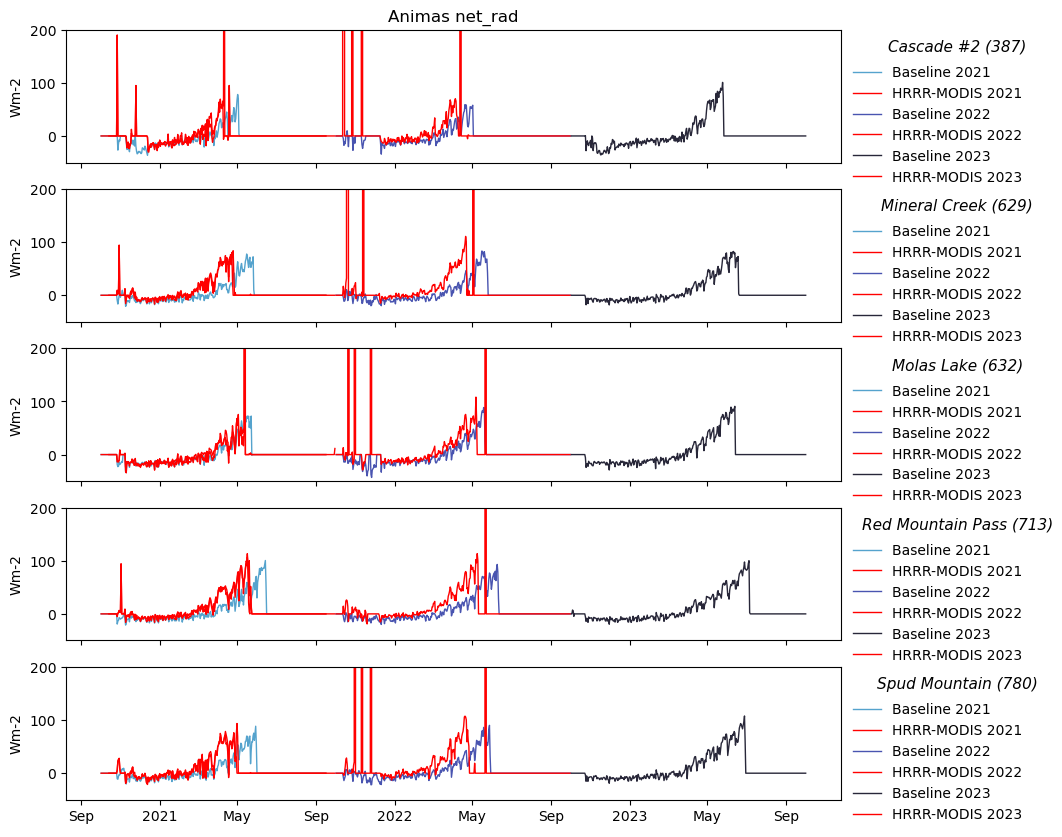

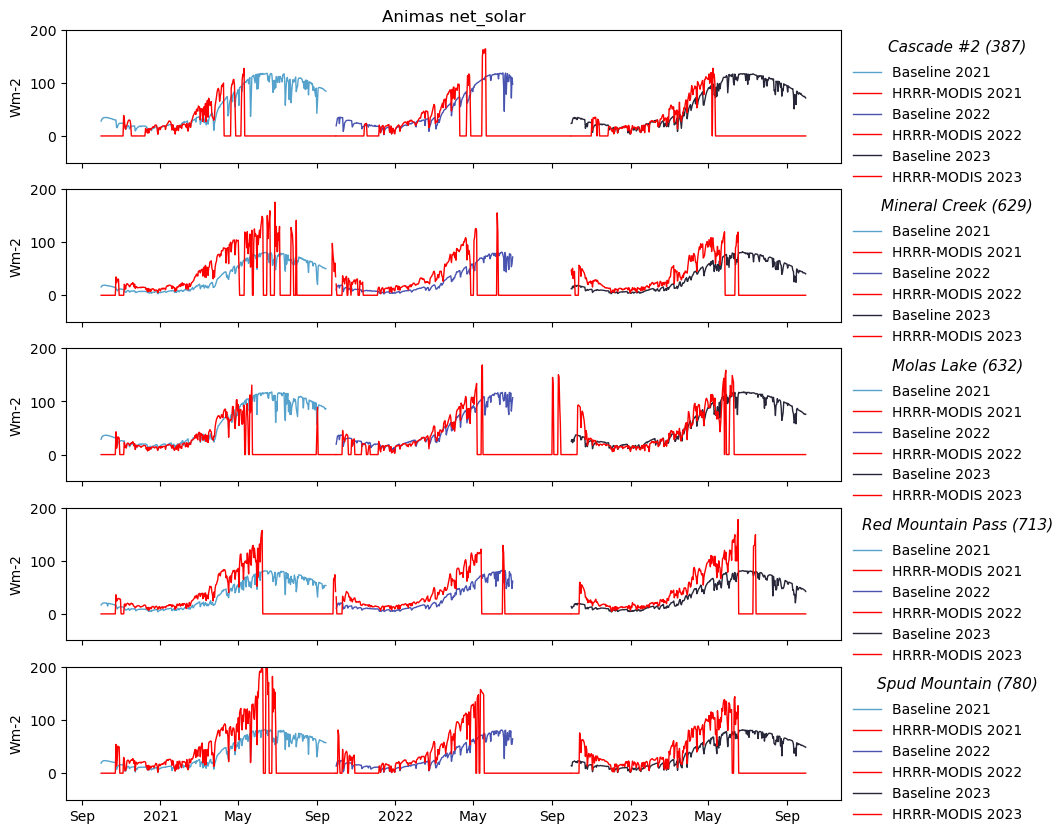

In [42]:
# For the full time series, plot each year's variables on the same plot
# Loop through each variable
ylims = -20, 500
for data_var in ['DSWRF', 'net_rad', 'net_solar']:
    print(data_var)
    fig, axa = plt.subplots(1*len(sitenames), 1, figsize=(10,2*len(sitenames)), sharex=True, sharey=True)
    # Loop through sites
    for sdx, sitename in enumerate(sitenames):
        ax = axa[sdx]
        # fig, ax = plt.subplots(1, 1, figsize=(10,2), sharex=True, sharey=True)
        # Plot DSWRF
        if data_var == 'DSWRF':
            for ds in dswrf_list:
                wy = str(ds['time'][-1].values).split('-')[0]
                ds[data_var][:, sdx, sdx].plot(ax=ax, label=f'Raw DSWRF {wy}',
                                    #  color='lightgrey',
                                     linewidth=0.75, linestyle='-')
            for ds in hm_netsolar_list:
                wy = str(ds['time'][-1].values).split('-')[0]
                ds[data_var][:, sdx, sdx].plot(ax=ax, label=f'net HRRR MODIS {wy}',
                                     color='red', marker='.', markersize=2,
                                     linestyle='None')
            ax = h.prep_axis(ax=ax, ylims=ylims, fc=None, xlab='', ylab='Wm-2')
        # Plot net radiation
        elif data_var == 'net_rad':
            halfway = len(em_list) // 2
            for ds_baseline, ds_hm in zip(em_list[:halfway], em_list[halfway:]):
                wy = str(ds_baseline['time'][-1].values).split('-')[0]
                ds_baseline[data_var][:, sdx, sdx].plot(ax=ax, label=f'Baseline {wy}',
                                                        #  color='red',
                                                         linewidth=1, linestyle='-')
                ds_hm[data_var][:, sdx, sdx].plot(ax=ax, label=f'HRRR-MODIS {wy}', color='red', linewidth=1, linestyle='-')
            ax = h.prep_axis(ax=ax, ylims=(-50, 200), fc=None, xlab='', ylab='Wm-2')
        # Plot albedo and net solar radiation
        elif data_var == 'net_solar':
            for ds_baseline, ds_hm in zip(baseline_netsolar_list, hm_netsolar_list):
                wy = str(ds_baseline['time'][-1].values).split('-')[0]
                ds_baseline[data_var][:, sdx, sdx].plot(ax=ax, label=f'Baseline {wy}',
                                                        # color='red',
                                                        linewidth=1, linestyle='-')
                ds_hm[data_var][:, sdx, sdx].plot(ax=ax, label=f'HRRR-MODIS {wy}', color='red',linewidth=1, linestyle='-')
            ax = h.prep_axis(ax=ax, ylims=(-50, 200), fc=None, xlab='', ylab='Wm-2')
        if sdx == 0:
            ax.set_title(f'{basin.capitalize()} {data_var}')
        else:
            ax.set_title('')
        ax.set_xlabel('')

        ax.annotate(sitename, xy=(1.15, 0.84), xycoords='axes fraction', ha='center', fontsize=11, fontstyle='italic')
        ax.legend(loc='upper right', bbox_to_anchor=(1.25, 0.825), fontsize=10, frameon=False)
# Plot snow depth (hm, baseline, snotel) on the second axis for net solar and net radiation plots (can also do this in another plot below)

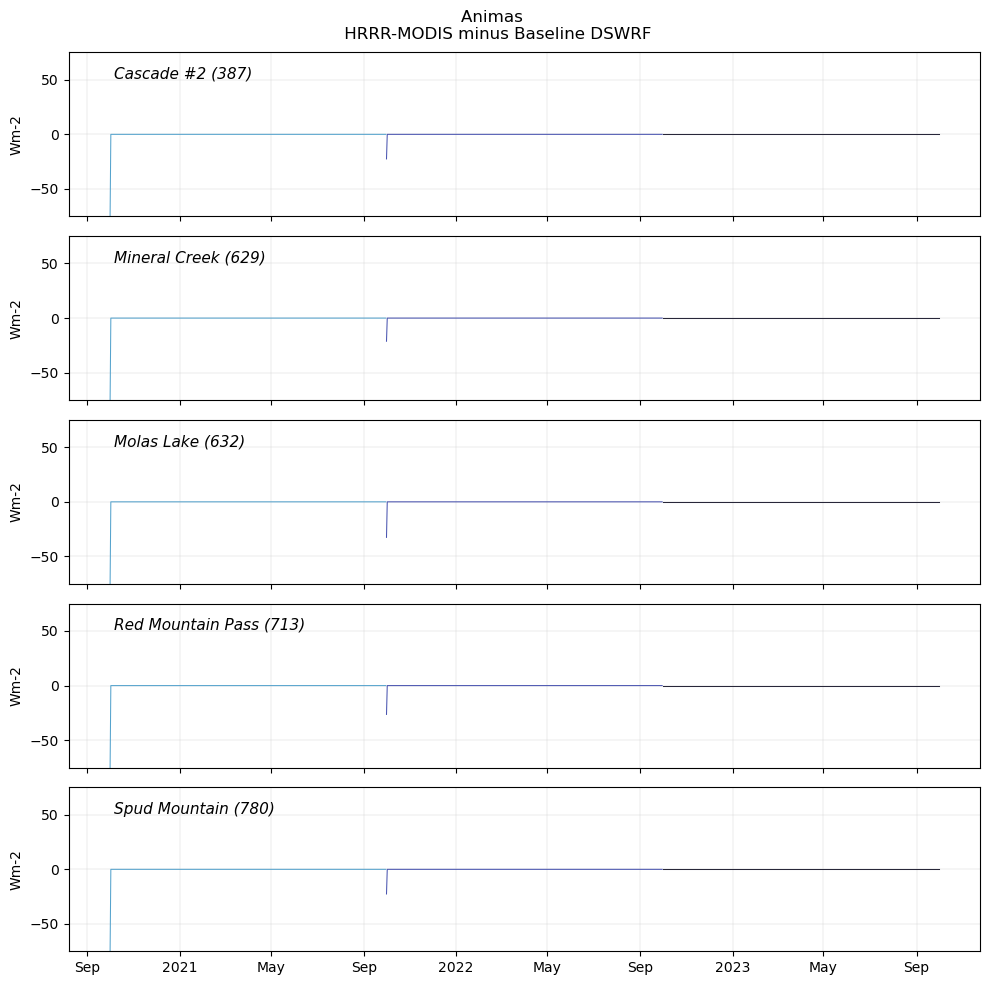

In [43]:
# Plot just the differences now
data_var = 'DSWRF'
# Loop through sites
fig, axa = plt.subplots(len(sitenames), 1, figsize=(10,2*len(sitenames)), sharex=True, sharey=True)
for sdx, sitename in enumerate(sitenames):
    ax = axa[sdx]
    for ds_baseline, ds_hm in zip(dswrf_list, hm_netsolar_list):
        wy = str(ds['time'][-1].values).split('-')[0]
        (ds_hm[data_var][:, sdx, sdx] - ds_baseline[data_var][:, sdx, sdx]).plot(ax=ax, label=f'{wy}',
                                linewidth=0.75, linestyle='-')
    ax.annotate(sitename, xy=(0.05, 0.84), xycoords='axes fraction', ha='left', fontsize=11, fontstyle='italic')
    ylims = (-75, 75)
    ax = h.prep_axis(ax=ax, ylims=ylims, fc=None, xlab='', ylab='Wm-2')
    ax.set_xlabel('')
    ax.set_title('')
    ax.grid(color='lightgrey', linewidth=0.3, which='both')
plt.suptitle(f'{basin.capitalize()} \n HRRR-MODIS minus Baseline DSWRF')
plt.tight_layout()


In [44]:
def trim_time_vals(in_time_arr: np.array, verbose: bool = False) -> np.array:
    # Trim the time values to just the date
    in_time_arr = [str(in_time_str).split('T')[0] for in_time_str in in_time_arr]
    if verbose:
        print(in_time_arr)
    return in_time_arr

def check_dubious_values(da, thresh, verbose=False):
    import copy
    da2check = copy.deepcopy(da)
    # # Find value and time of values > thresh Regular threshold approach
    # da2check = da2check.where(da2check > thresh)
    # Find spikes using first derivative where the increase is greater than the threshold in a single day
    da2check = da2check.where(da2check.diff(dim='time') > thresh)
    if verbose:
        print(da2check[da2check.notnull()].values, da2check[da2check.notnull()].time.values)
    return da2check[da2check.notnull()]

In [45]:
# When are spikes occurring?
for data_var in ['DSWRF', 'net_rad']: #, 'net_solar']:
    print(f'\n=== {data_var} ===')
    # Loop through sites
    for sdx, sitename in enumerate(sitenames):
        # DSWRF
        print(sitename)
        if data_var == 'DSWRF':
            for ds1, ds2 in zip(dswrf_list, hm_netsolar_list):
                wy = str(ds1['time'][-1].values).split('-')[0]
                thresh = 500
                da_dubious = check_dubious_values(da=ds1[data_var][:, sdx, sdx], thresh=thresh)
                if len(da_dubious) > 0:
                    # print(f'    {wy} Raw DSWRF {da_dubious.values} {trim_time_vals(da_dubious.time.values)}')
                    print(f'    {wy} Raw DSWRF {trim_time_vals(da_dubious.time.values)}')
                da_dubious = check_dubious_values(da=ds2[data_var][:, sdx, sdx], thresh=thresh)
                if len(da_dubious) > 0:
                    # print(f'    {wy} Net Solar DSWRF {da_dubious.values} {trim_time_vals(da_dubious.time.values)}')
                    print(f'    {wy} Net Solar DSWRF {trim_time_vals(da_dubious.time.values)}')
        # net radiation
        elif data_var == 'net_rad':
            for ds_baseline, ds_hm in zip(em_list[:3], em_list[3:]):
                wy = str(ds_baseline['time'][-1].values).split('-')[0]
                thresh = 75
                da_dubious = check_dubious_values(da=ds_baseline[data_var][:, sdx, sdx], thresh=thresh)
                if len(da_dubious) > 0:
                    # print(f'    {wy} Baseline {da_dubious.values} {trim_time_vals(da_dubious.time.values)}')
                    print(f'    {wy} Baseline {trim_time_vals(da_dubious.time.values)}')
                da_dubious = check_dubious_values(da=ds_hm[data_var][:, sdx, sdx], thresh=thresh)
                if len(da_dubious) > 0:
                    # print(f'    {wy} HRRR-MODIS {da_dubious.values} {trim_time_vals(da_dubious.time.values)}')
                    print(f'    {wy} HRRR-MODIS {trim_time_vals(da_dubious.time.values)}')
        # net solar radiation
        elif data_var == 'net_solar':
            for ds_baseline, ds_hm in zip(baseline_netsolar_list, hm_netsolar_list):
                wy = str(ds_baseline['time'][-1].values).split('-')[0]
                thresh = 150
                da_dubious = check_dubious_values(da=ds_baseline[data_var][:, sdx, sdx], thresh=thresh)
                if len(da_dubious) > 0:
                    # print(f'    {wy} Baseline {da_dubious.values} {trim_time_vals(da_dubious.time.values)}')
                    print(f'    {wy} Baseline {trim_time_vals(da_dubious.time.values)}')
                da_dubious = check_dubious_values(da=ds_hm[data_var][:, sdx, sdx], thresh=thresh)
                if len(da_dubious) > 0:
                    # print(f'    {wy} HRRR-MODIS {da_dubious.values} {trim_time_vals(da_dubious.time.values)}')
                    print(f'    {wy} HRRR-MODIS {trim_time_vals(da_dubious.time.values)}')



=== DSWRF ===
Cascade #2 (387)
    2021 Raw DSWRF ['2020-11-13', '2020-12-12']
    2021 Net Solar DSWRF ['2020-11-13', '2020-12-12']
Mineral Creek (629)
    2021 Raw DSWRF ['2020-11-13', '2020-12-12']
    2021 Net Solar DSWRF ['2020-11-13', '2020-12-12']
Molas Lake (632)
    2021 Raw DSWRF ['2020-11-13', '2020-12-12']
    2021 Net Solar DSWRF ['2020-11-13', '2020-12-12']
Red Mountain Pass (713)
    2021 Raw DSWRF ['2020-11-13', '2020-12-12']
    2021 Net Solar DSWRF ['2020-11-13', '2020-12-12']
Spud Mountain (780)
    2021 Raw DSWRF ['2020-11-13', '2020-12-12']
    2021 Net Solar DSWRF ['2020-11-13', '2020-12-12']

=== net_rad ===
Cascade #2 (387)
    2021 HRRR-MODIS ['2020-10-26', '2020-11-24', '2021-04-18']
    2022 HRRR-MODIS ['2020-10-26', '2020-11-24', '2021-04-10', '2021-04-18']
    2023 HRRR-MODIS ['2021-10-12', '2021-10-26', '2021-11-10', '2022-04-12']
Mineral Creek (629)
    2021 HRRR-MODIS ['2020-10-29']
    2022 HRRR-MODIS ['2020-10-29']
    2023 HRRR-MODIS ['2021-10-18', '

# Longwave

In [71]:
# Where are spikes in net radiation coming from? Check longwave
# Plot longwave for HM and Baseline (smrf - thermal)
# Load the files anew
baseline_lw_list = [xr.open_dataset(f).resample(time='1D').mean() for f in h.fn_list(workdir, f'*{basin}_Baseline_smrf_2*')]
hm_lw_list = [xr.open_dataset(f).resample(time='1D').mean() for f in h.fn_list(workdir, f'*{basin}_HRRR-MODIS_smrf_2*')]
print(len(baseline_lw_list), len(hm_lw_list))
# baseline_em_list


3 3


In [72]:
import seaborn as sns
sns.set_palette('icefire')

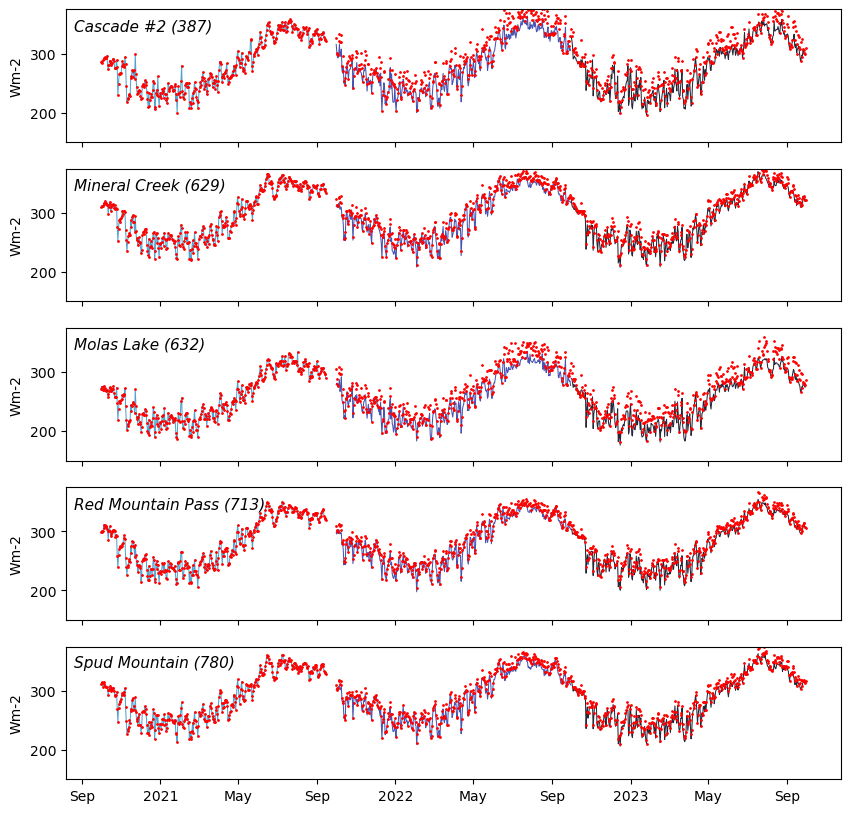

In [73]:
data_var = 'thermal'
# Loop through sites
fig, axa = plt.subplots(len(sitenames), 1, figsize=(10,2*len(sitenames)), sharex=True, sharey=True)
for sdx, sitename in enumerate(sitenames):
    ax = axa[sdx]
    # fig, ax = plt.subplots(1, 1, figsize=(10,2), sharex=True, sharey=True)
    for ds in baseline_lw_list:
        wy = str(ds['time'][-1].values).split('-')[0]
        ds[data_var][:, sdx, sdx].plot(ax=ax, label=f'{wy}',
                            #  color='lightgrey',
                                linewidth=0.75, linestyle='-')
    for ds in hm_lw_list:
        ds[data_var][:, sdx, sdx].plot(ax=ax, label=f'{wy}',
                                color='red', marker='.', markersize=2,
                                linestyle='None')
    ylims = (150, 375)
    ax = h.prep_axis(ax=ax, ylims=ylims, fc=None, xlab='', ylab='Wm-2')
    ax.set_title('')
    ax.set_xlabel('')
    ax.annotate(sitename, xy=(0.01, 0.84), xycoords='axes fraction', ha='left', fontsize=11, fontstyle='italic')

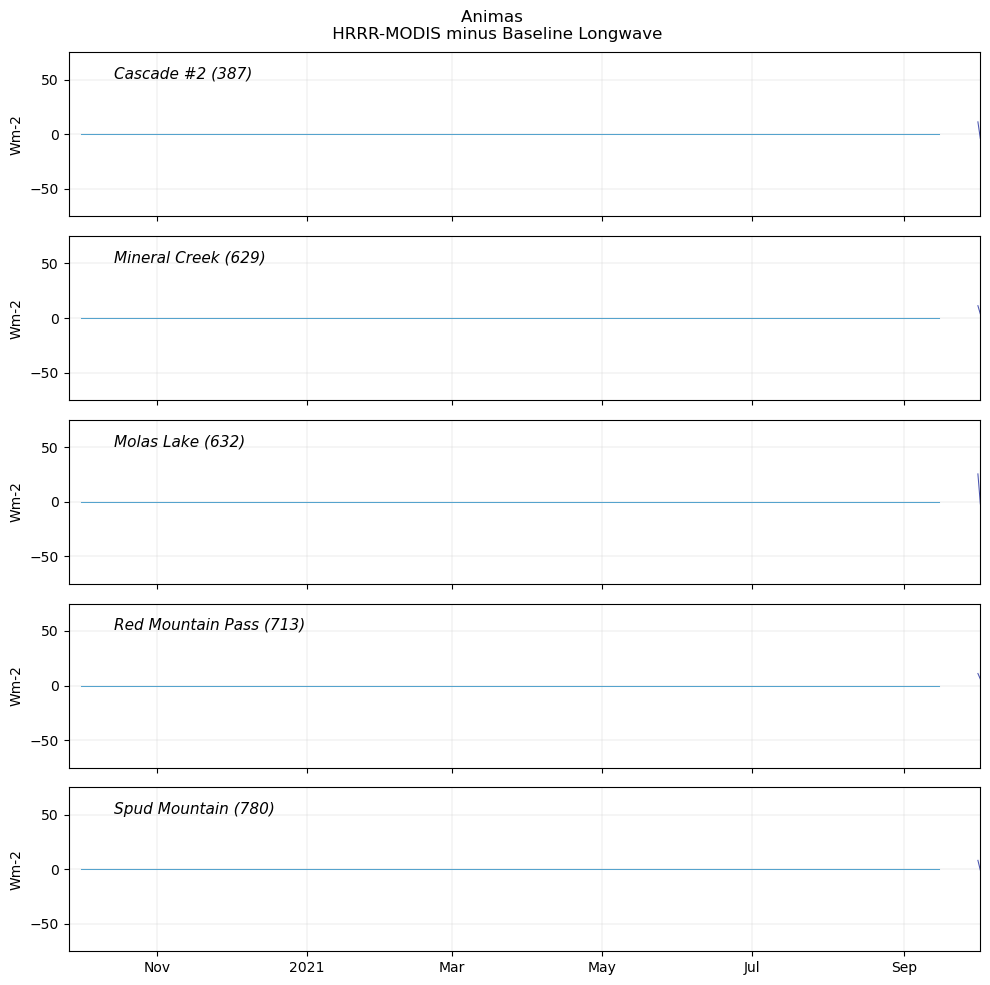

In [74]:
# Plot just the differences now
data_var = 'thermal'
# Loop through sites
fig, axa = plt.subplots(len(sitenames), 1, figsize=(10,2*len(sitenames)), sharex=True, sharey=True)
for sdx, sitename in enumerate(sitenames):
    ax = axa[sdx]
    for ds_baseline, ds_hm in zip(baseline_lw_list, hm_lw_list):
        wy = str(ds['time'][-1].values).split('-')[0]
        (ds_hm[data_var][:, sdx, sdx] - ds_baseline[data_var][:, sdx, sdx]).plot(ax=ax, label=f'{wy}',
                                linewidth=0.75, linestyle='-')
    ax.annotate(sitename, xy=(0.05, 0.84), xycoords='axes fraction', ha='left', fontsize=11, fontstyle='italic')
    ylims = (-75, 75)
    ax = h.prep_axis(ax=ax, ylims=ylims, fc=None, xlab='', ylab='Wm-2')
    ax.set_xlabel('')
    ax.set_title('')
    ax.set_xlim(xlims)
    ax.grid(color='lightgrey', linewidth=0.3, which='both')
plt.suptitle(f'{basin.capitalize()} \n HRRR-MODIS minus Baseline Longwave')
plt.tight_layout()

# xlims = ax.get_xlim()
# xlims

In [50]:
# if basin is not animas, stop cell execution here
if basin != 'animas':
    raise Exception('Basin is not animas, stopping execution')

# Compare MODIS albedo with SBB field albedo

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Plot raw MODIS albedo and processed net_HRRR_MODIS albedo at SBB
# Senator Beck Study Plot (Alpine): 37.906900624490504, -107.72625795815301
# Swamp Angel Study Plot (Subalpine): 37.906965992923794, -107.71133466651288
SBSP_lat = 37.906900624490504
SBSP_lon = -107.72625795815301
SASP_lat = 37.906965992923794
SASP_lon = -107.71133466651288

# Turn into a geodataframe of points
SBB_gdf = gpd.GeoDataFrame(geometry=[Point(SASP_lon, SASP_lat), Point(SBSP_lon, SBSP_lat)], crs='EPSG:4326')

# Reproject to 32613
SBB_gdf = SBB_gdf.to_crs(32613)
SBB_gdf

In [ ]:
model_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/'
# Open the net_HRRR_MODIS albedo files for all three water years and pull the albedo data from the sites
# for wy in [2021, 2022, 2023]:
for wy in [2022]:
    print(wy)
    outname = f'{workdir}/net_HRRR_MODIS_albedo_{basin}_sampled_SBB_{wy}.nc'
    if not os.path.exists(outname):
        print('Opening albedo data')
        net_HRRR_MODIS_albedo_list = [xr.open_dataset(f, chunks='auto', drop_variables=['illumination_angle', 'transverse_mercator']) for f in h.fn_list(model_dir, f'{basin}*/wy{wy}/*albedo/run*/net_solar.nc')]
        net_HRRR_MODIS_albedo_list = xr.open_mfdataset(h.fn_list(model_dir, f'{basin}*/wy{wy}/*/run*/net_solar.nc'), combine='by_coords', chunks='auto')

        # Resample to daily values and extract at the SBB sites
        print('Resampling and extracting')
        net_HRRR_MODIS_albedo_sampled = net_HRRR_MODIS_albedo_list.resample(time='1D').mean().sel(x=list(SBB_gdf.geometry.x.values), y=list(SBB_gdf.geometry.y.values), method='nearest')

        # Save to file
        print('Saving to file')
        net_HRRR_MODIS_albedo_sampled.to_netcdf(outname, mode='w',
                                                format='NETCDF4', engine='netcdf4', encoding={'albedo': {'zlib': True, 'complevel': 5}})
        del net_HRRR_MODIS_albedo_sampled
    else:
        print(f'Already exists: {outname}')
        net_HRRR_MODIS_albedo_sampled = xr.open_dataset(outname)

In [ ]:
# Plot the MODIS albedo at SBB
fig, ax = plt.subplots(figsize=(10, 4))
(net_HRRR_MODIS_albedo_sampled['albedo'][:, 0, 0] / 10000).plot(label='SBSP')
(net_HRRR_MODIS_albedo_sampled['albedo'][:, 1, 1] / 10000).plot(label='SASP')
h.prep_axis(ax=ax, xlab='Date', ylab='Albedo', fc=None, turnofflabels=True)
ax.set_title('')

In [51]:
# Now pull in SBB data using metloom - no, they don't have everything, just get the PoR csv directly from CSAS https://snowstudies.org/archival-data/
# This is located on CSAS network
# !wget https://snowstudies.org/wp-content/uploads/2023/11/SASP_1hr_2010-2023.csv
# !wget https://snowstudies.org/wp-content/uploads/2023/11/SBSP_1hr_2010-2023.csv

In [52]:
# # This is where the corrected data lives
# # https://zenodo.org/records/14675762
# !wget https://zenodo.org/records/14675762/files/sasp_corrected_radiation_2021.dat?download=1
# !wget https://zenodo.org/records/14675762/files/sasp_corrected_radiation_2022.dat?download=1
# !wget https://zenodo.org/records/14675762/files/sasp_corrected_radiation_2023.dat?download=1
# !wget https://zenodo.org/records/14675762/files/sbsp_corrected_radiation_2021.txt?download=1
# !wget https://zenodo.org/records/14675762/files/sbsp_corrected_radiation_2022.txt?download=1
# !wget https://zenodo.org/records/14675762/files/sbsp_corrected_radiation_2023.txt?download=1

In [53]:
# # These are the files that are from CSAS
# print(h.fn_list('.', '*1hr*csv'))

# # These are the files that are in the zenodo record
# print(h.fn_list('.', '*corrected*'))

In [54]:
# # Process the dat files and turn into csv_files
# for corrected_fn in h.fn_list('.', '*corrected*dat*'):
#     print(corrected_fn)
#     df = pd.read_csv(corrected_fn, sep='\s+', header=None)
#     df.columns = ['Year', 'Month', 'Day', 'Hour', 'DOY', 'kbb_in', 'kbb_rf', 'kbb_net', 'kbb_albedo',
#                   'kir_in', 'kir_rf', 'kir_net', 'kir_albedo', 'kvi_in', 'kvi_rf', 'kvi_net', 'kvi_albedo',
#                   'kbb_net_ndmin', 'kbb_net_ndmax', 'rfdust_bb', 'rfdust_vis', 'rfdust_nir']
#     csv_fn = corrected_fn.split('.dat')[0] + '.csv'
#     print(csv_fn)
#     df.to_csv(csv_fn, index=False)

In [55]:
# # Now do the same with the txt files
# for corrected_fn in h.fn_list('.', '*corrected*txt*'):
#     print(corrected_fn)
#     df = pd.read_csv(corrected_fn, sep='\s+', header=None)
#     df.columns = ['Year', 'Month', 'Day', 'Hour', 'DOY', 'kbb_in', 'kbb_rf', 'kbb_net', 'kbb_albedo',
#                   'kir_in', 'kir_rf', 'kir_net', 'kir_albedo', 'kvi_in', 'kvi_rf', 'kvi_net', 'kvi_albedo',
#                   'kbb_net_ndmin', 'kbb_net_ndmax', 'rfdust_bb', 'rfdust_vis', 'rfdust_nir']
#     csv_fn = corrected_fn.split('.txt')[0] + '.csv'
#     print(csv_fn)
#     df.to_csv(csv_fn, index=False)

In [ ]:
# Now read these files back in for the correct WY
csv_list = h.fn_list('.', f'*corrected*{wy}.csv')
csv_list

In [57]:
def process_corrected_albedo(overpasshour, csv_list):
    # Read them in and drop all but broadband albedo and date info
    df_list = [pd.read_csv(csv, usecols=['Year', 'Month', 'Day', 'Hour', 'DOY', 'kbb_albedo']) for csv in csv_list]

    # Extract no data values
    ndv = df_list[0]['kbb_albedo'].min()

    # Drop the index column, using the datetime instead
    for df in df_list:
        # Create a datetime column
        df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
        # Set the datetime as the index
        df.set_index('datetime', inplace=True)

        # Extract only the overpasshour of interest
        df.drop(df[(df['Hour'] != overpasshour)].index, inplace=True)

        # Drop the original columns
        df.drop(columns=['Year', 'Month', 'Day', 'Hour'], inplace=True)
        # Change the no data values to nans
        df['kbb_albedo'].replace(ndv, np.nan, inplace=True)

    return df_list, ndv

In [ ]:
overpasstime = 10
df_list, ndv = process_corrected_albedo(overpasshour=overpasstime, csv_list=csv_list)

In [59]:
def npfloat64_2_datetime64(inval):
    # Convert the float64 to datetime64 by first converting to seconds
    converted_seconds = inval * 3600 * 24
    converted = np.array([int(converted_seconds)], dtype='datetime64[s]')
    return converted

def str_2_npfloat64(instr: str):
    '''
    Convert input string to posix integer timestamp
    Parameters
    ----------
    instr: "YYYY-MM-DD"
    '''
    import datetime
    return datetime.datetime.strptime(instr, '%Y-%m-%d').timestamp() / 3600 / 24

# npfloat64_2_datetime64(xlims[0])
# str_2_npfloat64(f'{WY}-7-15')

In [ ]:
# Plot MODIS albedo on top of SASP albedo
site = 'SASP'
siteidx = 0
var = 'kbb_albedo'
# Read it back in
fig, axa = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
ax = axa[0]
(net_HRRR_MODIS_albedo_sampled['albedo'][:, siteidx, siteidx] / 10000).plot(ax=ax, linewidth=1.5, label=f'MODIS albedo at {site}', c='royalblue')
# xlims = ax.get_xlim()
# End at July 15 to make better use of whitespace on the plot
xlims = (ax.get_xlim()[0], str_2_npfloat64(f'{wy}-7-15'))
df_list[siteidx][var].plot(ax=ax, label=f'{site} albedo', marker='o', markersize=3, linestyle='None', color='navy')
ax.set_xlim(xlims)
ax.set_ylim(0, 1.2)
ax.set_title('')
h.prep_axis(ax=ax, xlab='', ylab='Albedo', fc=None)
fig.legend(ncol=4, loc='upper right', bbox_to_anchor=(0.9, 0.95), fontsize=10, frameon=False)
plt.suptitle(f'{basin.capitalize()} WY {wy}: {int(overpasstime)}AM at {site}') # hours is in hundreds for CSAS, regular for corrected
ax.grid(color='lightgrey', linewidth=0.7, linestyle='--')

# Plot the difference on a second subplot
ax = axa[1]
((net_HRRR_MODIS_albedo_sampled['albedo'][:, siteidx, siteidx] / 10000) - df_list[siteidx][var]).plot(ax=ax,
                                                                                            label=f'MODIS - {site} albedo', marker='x', markersize=4, color='k', linestyle='None')
ax.set_ylim(-0.6, 0.6)
ax.hlines(xmin=xlims[0], xmax=xlims[1], y=0, color='maroon', linewidth=0.5)
ax.set_title('')
ax.grid(color='lightgrey', linewidth=0.7, linestyle='--')
ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(0.95, 1.15), fontsize=10)

In [ ]:
df_list[0][var]

In [62]:
import numpy as np
f = (net_HRRR_MODIS_albedo_sampled['albedo'][:, siteidx, siteidx] / 10000) - df_list[siteidx][var]
f = f.values
f = f[~np.isnan(f)]
f;

In [ ]:
# plot a boxplot of values
fig, axa = plt.subplots(1, 2, figsize=(10, 4))
ax = axa[0]
sns.boxplot(f, ax=ax, width=0.1)
ax.set_ylim(-0.6, 0.6)
ax.set_title(f'MODIS - {site} albedo')
ax.set_ylabel('Albedo Difference')
ax.grid(color='lightgrey', linewidth=0.7, linestyle='--')

# Plot the histogram of values
ax = axa[1]
sns.histplot(f, ax=ax, bins=20, kde=False)
ax.set_xlim(-0.6, 0.6)
# Add stats as annotations
mean = np.nanmean(f)
median = np.nanmedian(f)
std = np.nanstd(f)
ax.annotate(f'Mean: {mean:.2f}', xy=(0.6, 0.9), xycoords='axes fraction', fontsize=10)
ax.annotate(f'Median: {median:.2f}', xy=(0.6, 0.85), xycoords='axes fraction', fontsize=10)
ax.annotate(f'Std: {std:.2f}', xy=(0.6, 0.8), xycoords='axes fraction', fontsize=10)
plt.suptitle(f'{basin.capitalize()} WY {wy}: {int(overpasstime)}AM at {site}') # hours is in hundreds for CSAS, regular for corrected


In [ ]:
# Plot MODIS albedo on top of SBSP albedo
site = 'SBSP'
siteidx = 1
var = 'kbb_albedo'
# Read it back in
fig, axa = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
ax = axa[0]
(net_HRRR_MODIS_albedo_sampled['albedo'][:, siteidx, siteidx] / 10000).plot(ax=ax, linewidth=1.5, label=f'MODIS albedo at {site}', c='royalblue')
xlims = ax.get_xlim()
df_list[siteidx][var].plot(ax=ax, label=f'{site} albedo', marker='o', markersize=3, linestyle='None', color='navy')
ax.set_xlim(xlims)
ax.set_ylim(0, 1.2)
ax.set_title('')
h.prep_axis(ax=ax, xlab='', ylab='Albedo', fc=None)
fig.legend(ncol=4, loc='upper right', bbox_to_anchor=(0.9, 0.95), fontsize=10, frameon=False)
plt.suptitle(f'{basin.capitalize()} WY {wy}: {int(overpasstime)}AM at {site}') # hours is in hundreds for CSAS, regular for corrected
ax.grid(color='lightgrey', linewidth=0.7, linestyle='--')

# Plot the difference on a second subplot
ax = axa[1]
((net_HRRR_MODIS_albedo_sampled['albedo'][:, siteidx, siteidx] / 10000) - df_list[siteidx][var]).plot(ax=ax,
                                                                                            label=f'MODIS - {site} albedo', marker='x', markersize=4, color='k', linestyle='None')
ax.set_ylim(-0.6, 0.6)
ax.hlines(xmin=xlims[0], xmax=xlims[1], y=0, color='maroon', linewidth=0.5)
ax.set_title('')
ax.grid(color='lightgrey', linewidth=0.7, linestyle='--')
ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(0.95, 1.15), fontsize=10)

In [65]:
f = (net_HRRR_MODIS_albedo_sampled['albedo'][:, siteidx, siteidx] / 10000) - df_list[siteidx][var]
f = f.values
f = f[~np.isnan(f)]
f;

In [ ]:
# plot a boxplot of values
fig, axa = plt.subplots(1, 2, figsize=(10, 4))
ax = axa[0]
sns.boxplot(f, ax=ax, width=0.1)
ax.set_ylim(-0.6, 0.6)
ax.set_title(f'MODIS - {site} albedo')
ax.set_ylabel('Albedo Difference')
ax.grid(color='lightgrey', linewidth=0.7, linestyle='--')

# Plot the histogram of values
ax = axa[1]
sns.histplot(f, ax=ax, bins=20, kde=False)
ax.set_xlim(-0.6, 0.6)
# Add stats as annotations
mean = np.nanmean(f)
median = np.nanmedian(f)
std = np.nanstd(f)
ax.annotate(f'Mean: {mean:.2f}', xy=(0.6, 0.9), xycoords='axes fraction', fontsize=10)
ax.annotate(f'Median: {median:.2f}', xy=(0.6, 0.85), xycoords='axes fraction', fontsize=10)
ax.annotate(f'Std: {std:.2f}', xy=(0.6, 0.8), xycoords='axes fraction', fontsize=10)
plt.suptitle(f'{basin.capitalize()} WY {wy}: {int(overpasstime)}AM at {site}') # hours is in hundreds for CSAS, regular for corrected


In [59]:
# def process_csas_albedo_df_list(csv_fns, start, end, overpasshour=1000):
#     '''This is just for the CSAS data'''
#     # Read in the csv files
#     # Columns of interest (in general)
#     # 'Year', 'DOY', 'Hour', 'PyDwn_Unfilt_W', 'PyDwn_Filt_W', 'PyUp_Unfilt_W', 'PyUp_Filt_W', 'PyUp_Shad_W', 'Pyrgeom_W', 'Sno_IR_C', 'Sno_Gd_C', 'Sno_10cm_C', 'Sno_20cm_C', 'Sno_30cm_C', 'Sno_40cm_C', 'Sno_Height_M',
#     # Just focus on albedo (reflected / incoming) comparison, but pull all radiation bits
#     df_list = [pd.read_csv(csv,
#                            usecols=['Year', 'DOY', 'Hour', 'PyDwn_Unfilt_W', 'PyDwn_Filt_W', 'PyUp_Unfilt_W', 'PyUp_Filt_W', 'PyUp_Shad_W', 'Pyrgeom_W'],
#                            ) for csv in csv_fns]

#     # One bad value (empty string) replace with nan
#     for df in df_list:
#         # print(df['PyUp_Unfilt_W'].isnull().sum())
#         df['PyUp_Unfilt_W'].replace(to_replace=' ', value=np.nan, inplace=True)
#         # print(df['PyUp_Unfilt_W'].isnull().sum())

#     # Specify dtypes as int or float
#     for df in df_list:
#         df['Year'] = df['Year'].astype(int)
#         df['DOY'] = df['DOY'].astype(int)
#         df['Hour'] = df['Hour'].astype(int)
#         df['PyDwn_Unfilt_W'] = df['PyDwn_Unfilt_W'].astype(float)
#         df['PyDwn_Filt_W'] = df['PyDwn_Filt_W'].astype(float)
#         df['PyUp_Unfilt_W'] = df['PyUp_Unfilt_W'].astype(float)
#         df['PyUp_Filt_W'] = df['PyUp_Filt_W'].astype(float)
#         df['PyUp_Shad_W'] = df['PyUp_Shad_W'].astype(float)
#         df['Pyrgeom_W'] = df['Pyrgeom_W'].astype(float)

#     # Drop all rows that aren't during the 10 AM / 11 AM overpass times
#     for df in df_list:
#         df.drop(df[(df['Hour'] != overpasshour)].index, inplace=True)

#     # Prepare processed df_list
#     final_df_list = []
#     # Create a date column using Year, DOY, and Hour in military time
#     for df in df_list:
#         df['DOY'] = df['DOY'].astype(str).str.zfill(3)  # Pad with zeros to make it 3 digits total
#         df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['DOY'].astype(str), format='%Y-%j')

#         # convert hour to nanoseconds and then as timedelta
#         df['Date'] = df['Date'] + pd.to_timedelta((df['Hour']/100*60*60*1e9), unit='ns')  # Add hours to the date

#         # Set the index to the date column
#         df.set_index('Date', inplace=True)

#         # Drop the other columns
#         df.drop(columns=['Year', 'DOY', 'Hour'], inplace=True)

#         # Calculate albedo: ratio of reflected (down-looking pyranometer) radiation to incoming (up-looking pyranometer) radiation
#         df['albedo_bb'] = df['PyDwn_Unfilt_W'] / df['PyUp_Unfilt_W']

#         # Crop to time period of interest
#         cropped_df = df.loc[start:end]
#         print(cropped_df.shape)
#         final_df_list.append(cropped_df)

#     return final_df_list


# csv_list = h.fn_list('.', '*1hr*csv')
# print(csv_list)
# start = f'{wy-1}-10-01'
# end = f'{wy}-09-30'
# overpasstime = 1000
# df_list = process_csas_albedo_df_list(csv_fns=csv_list, start=start, end=end, overpasshour=overpasstime)

In [60]:
# # Plot MODIS albedo on top of SASP albedo
# # Read it back in
# fig, ax = plt.subplots(figsize=(18, 5))
# (net_HRRR_MODIS_albedo_sampled['albedo'][:, 1, 1] / 10000).plot(ax=ax, linewidth=1.5, label='MODIS albedo at SASP', c='magenta')
# xlims = ax.get_xlim()
# df_list[0]['albedo_bb'].plot(ax=ax, label='SASP albedo', marker='.', markersize=2, linestyle='None', color='royalblue')
# # df_list[0]['albedo_bb'].resample('D').mean().plot(ax=ax, label='SASP daily mean albedo', marker='x', markersize=4, color='r', linestyle='None')
# # df_list[0]['albedo_bb'].resample('D').max().plot(ax=ax, label='SASP daily max albedo', marker='o', markersize=4, color='k', linestyle='None')
# ax.set_xlim(xlims)
# ax.set_ylim(-0.2, 1.2)
# ax.set_title('')
# h.prep_axis(ax=ax, xlab='', ylab='Albedo', fc=None)
# fig.legend(ncol=4, loc='upper right', bbox_to_anchor=(0.9, 0.95), fontsize=10, frameon=False)
# ax.grid(color='lightgrey', linewidth=0.7, linestyle='--')

In [61]:
# Plot (snow temp_surf) -- this is missing for WY 2022 because it's not plotting properly